# Practical - Interest Rates Modeling


**Group composition**:
- Amal BACHA
- Lucas RODRIGUEZ

**Deadline**: Wednesday, November 23 2022

In [1]:
# Importing necessary libraries
import xlrd
import math
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit
from scipy.interpolate import interp1d
import warnings

# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

## Model routines implementation

### Function definitions

In [2]:
def SABR(alpha,beta,rho,nu,F,K,time,MKT): # all variables are scalars
    """
    Function computing the implied volatiliy for a single swaption
    ==> Core function of the script, all input data and iterations are modelled to fit this specification
    """
    
    if K <= 0:   # negative rates' problem, need to shift the smile
        # Computing SABR volatility and difference with market volatility
        VOL = 0
        diff = 0
        
    elif F == K: # ATM formula
        V = (F*K)**((1-beta)/2.)
        logFK = math.log(F/K)
        A = 1 + ( ((1-beta)**2*alpha**2)/(24.*(V**2)) + (alpha*beta*nu*rho)/(4.*V) + ((nu**2)*(2-3*(rho**2))/24.) ) * time
        B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
        
        # Computing SABR volatility and difference with market volatility
        VOL = (alpha/V)*A
        diff = VOL - MKT
        
    elif F != K: # not-ATM formula
        V = (F*K)**((1-beta)/2.)
        logFK = math.log(F/K)
        z = (nu/alpha)*V*logFK
        x = math.log( ( math.sqrt(1-2*rho*z+z**2) + z - rho ) / (1-rho) )
        A = 1 + ( ((1-beta)**2*alpha**2)/(24.*(V**2)) + (alpha*beta*nu*rho)/(4.*V) + ((nu**2)*(2-3*(rho**2))/24.) ) * time
        B = 1 + (1/24.)*(((1-beta)*logFK)**2) + (1/1920.)*(((1-beta)*logFK)**4)
        
        # Computing SABR volatility and difference with market volatility
        VOL = (nu*logFK*A)/(x*B)
        diff = VOL - MKT

    # Writing the output SABR volatility
    print(round(VOL,4))
    outvol.write('%r;' %round(VOL,4))
     
    # Writing the difference between SABR volatility and market volatility
    if MKT == 0:
        diff = 0
        vol_diff.write('%s;' %'No market data')
    else:
        vol_diff.write('%r;' %round(diff,4))

In [3]:
def smile(alpha, beta, rho, nu, F, K, time, MKT, i): # F, time and the parameters are scalars, K and MKT are vectors, i is the index for tenor/expiry label
    """
    Function computing the implied volatilities for a given "smile" pointed out 
    by the index i, F, time and the parameters which are scalars
    """
    print(label_ten[i] , '\t' , label_exp[i])
    
    # Writing the labels for tenor and expiry
    outvol.write('%s;%s;' %(label_ten[i],label_exp[i]))
    vol_diff.write('%s;%s;' %(label_ten[i],label_exp[i]))
    parameters.write('%s;%s;' %(label_ten[i],label_exp[i]))
    
    # Computing the SABR volatility for this configuration
    for j in range(len(K)):
        if K[0] <= 0:
            shift(F,K)
        SABR(alpha,beta,rho,nu,F,K[j],time,MKT[j])

    print()
    # Writing the difference between SABR volatility and market volatility
    outvol.write('\n')
    vol_diff.write('\n')
    
    # Writing the parameter values
    parameters.write('%f;%f;%f;%f;' %(alpha ,beta ,rho ,nu))
    parameters.write('\n')

In [4]:
def SABR_vol_matrix(alpha,beta,rho,nu,F,K,time,MKT): # F, time and the parameters are vectors, K and MKT are matrices
    """
    Function computing the implied volatilities for all combinations of swaptions.
    """
    print()
    #print((2+((num_strikes-1)/2))*'       '+'SABR VOLATILITIES')
    print('  ' , '\t' , 'strikes:')
    for i in range(num_strikes):
        print(label_strikes[i])
    print()
    
    # Writing necessary headers
    #outvol.write('%s;' %'SABR VOLATILITIES')
    #outvol.write('\n')
    #vol_diff.write('%s;' %'VOLATILITY DIFFERENCES')
    #vol_diff.write('\n')
    #parameters.write('%s;' %'PARAMETERS')
    #parameters.write('\n')
    outvol.write('%s;%s;' %(' ','strikes:'))
    vol_diff.write('%s;%s;' %(' ','strikes:'))
    
    # Writing labels
    for j in range(len(strike_spreads)):
        outvol.write('%s;' %label_strikes[j])
        vol_diff.write('%s;' %label_strikes[j])
    
    # Writing necessary headers
    outvol.write('\n')
    vol_diff.write('\n')
    print('tenor' , '\t' ,   'expiry')
    
    # Writing the parameter values
    parameters.write('%s;%s;%s;%s;%s;%s' %('tenor','expiry','alpha','beta','rho','nu'))
    parameters.write('\n')
    
    # Compting the smiles
    for i in range(len(F)):
        smile(alpha[i],beta[i],rho[i],nu[i],F[i],K[i],time[i],MKT[i],i)

In [5]:
def shift(F,K):
    """
    Function computing the shifted model, which allows to calibrate the parameters and to compute
    the implied volatilities for the whole smile
    """
    shift = 0.001 - K[0]
    for j in range(len(K)):
        # Translating the swaption's strike K and the forward rate F
        K[j] = K[j] + shift
        F = F + shift   

In [6]:
def objfunc(par,F,K,time,MKT):
    """
    Function computing the volatilities for a single smile, then sums
    the squares of all market differences.
    The fina lsquare root is the final quantity that we want to minimize
    """
    sum_sq_diff = 0
    
    if K[0]<=0:
        shift(F,K)
    
    for j in range(len(K)):
        if MKT[j] == 0:   
            diff = 0       
    
        elif F == K[j]: 
            V = (F*K[j])**((1-par[1])/2.)
            logFK = math.log(F/K[j])
            A = 1 + ( ((1-par[1])**2*par[0]**2)/(24.*(V**2)) + (par[0]*par[1]*par[3]*par[2])/(4.*V) + ((par[3]**2)*(2-3*(par[2]**2))/24.) ) * time
            B = 1 + (1/24.)*(((1-par[1])*logFK)**2) + (1/1920.)*(((1-par[1])*logFK)**4)

            # Computing SABR volatility and difference with market volatility
            VOL = (par[0]/V)*A
            diff = VOL - MKT[j]
        
        elif F != K[j]: 
            V = (F*K[j])**((1-par[1])/2.)
            logFK = math.log(F/K[j])
            z = (par[3]/par[0])*V*logFK
            x = math.log( ( math.sqrt(1-2*par[2]*z+z**2) + z - par[2] ) / (1-par[2]) )
            A = 1 + ( ((1-par[1])**2*par[0]**2)/(24.*(V**2)) + (par[0]*par[1]*par[3]*par[2])/(4.*V) + ((par[3]**2)*(2-3*(par[2]**2))/24.) ) * time
            B = 1 + (1/24.)*(((1-par[1])*logFK)**2) + (1/1920.)*(((1-par[1])*logFK)**4)
            
            # Computing SABR volatility and difference with market volatility
            VOL = (par[3]*logFK*A)/(x*B)
            diff = VOL - MKT[j]  
        
        sum_sq_diff = sum_sq_diff + diff**2  
        obj = math.sqrt(sum_sq_diff)
    return obj

The above function `objfunc(par,F,K,time,MKT)` will be considered to calibrate the SABR mode.

$\longrightarrow$ The calibration process is done using the next function, which performs a minimization process using the **SLSQP** (Sequential Least Squares Programming) under specified barrier constraints for each parameter to be found.

In [7]:
def calibration(starting_par,F,K,time,MKT):
    """
    Function performing the minimization process and updating the parameters' arrays 
    that make model volatilities as close as possible to market volatilities
    """
    for i in range(len(F)):
        x0 = starting_par
        bnds = ( (0.001,None) , (0,1) , (-0.999,0.999) , (0.001,None)  )
        res = minimize(objfunc, # for a constrained minimization of multivariate scalar functions
                       x0 , 
                       (F[i],K[i],time[i],MKT[i]),
                       bounds = bnds, 
                       method="SLSQP")
        alpha[i] = res.x[0]
        beta[i] = res.x[1]
        rho[i] = res.x[2]
        nu[i] = res.x[3]

### I/O (Inputs & Outputs) handling

We now set the I/O settings in order to be able to write on the three files

1. `outvol.csv` $\longrightarrow$ SABR model volatilities
2. `vol_diff.csv` $\longrightarrow$ Difference of volatilities between SABR model output and market data
3. `parameters.csv` $\longrightarrow$ Estimated parameters for each tenor/expiry couple

In [8]:
# Opening the FDs for each file
outvol = open(f'outvol.csv', 'w')             # file output of volatilities
vol_diff = open(f'vol_diff.csv', 'w')         # file output differences between SABR and Market volatilities
parameters = open(f'parameters.csv', 'w')     # file output parameters

# Loading input file = market data
INPUTFILE_NAME = "market_data.xlsx"
SHEET_NAME = "Swaptions data"
while True:
    try:
        #file_input = pd.read_excel(io=INPUTFILE_NAME, sheet_name=SHEET_NAME, header=True)
        file_input = xlrd.open_workbook("MAIN.xls")     # load market data
    except Exception as e:
        print(f'Input file is not in the directory! : {e}')
    break
    
# Switching to the given sheet
Market_data = file_input.sheet_by_name('Swaptions data')        # file input forward rates

### Setting swaptions characteristics

We now set the swaptions characteristics:

In [9]:
strike_spreads = []
j = 0

while True:
    try:
        strike_spreads.append(int(Market_data.cell(1,3+j).value))
        j = j+1
    except:
        break
num_strikes = len(strike_spreads)

expiries=[]
i=0
while True:
        try:
            expiries.append(Market_data.cell(2+i,1).value)
            i = i + 1
        except:
            break

tenors=[]
i=0
while True:
    try:
        tenors.append(Market_data.cell(2+i,0).value)
        i = i + 1
    except:
        break


# to create the ATM forward rates
F = []
i=0
while True:
    try:
        F.append(Market_data.cell(2+i,2).value)
        i = i+1
    except:
        break

# to create the strike grid
K = numpy.zeros((len(F),num_strikes))
for i in range(len(F)):
    for j in range(num_strikes):
        K[i][j] = F[i] + 0.0001*(strike_spreads[j])  

# to create market volatilities            
MKT = numpy.zeros((len(F),num_strikes))
for i in range(len(F)):
    for j in range(num_strikes):
        MKT[i][j] = Market_data.cell(2+i,3+j).value


# set starting parameters
starting_guess = numpy.array([0.001,0.5,0,0.001]) # x_0
alpha = len(F)*[starting_guess[0]]
beta = len(F)*[starting_guess[1]]
rho = len(F)*[starting_guess[2]]
nu = len(F)*[starting_guess[3]]

### Setting labels

The final step before calling functions, we establish each label for the file description: 

In [10]:
exp_dates = len(expiries)*[0]
for i in range(len(expiries)):
    if expiries[i] < 1:
        exp_dates[i] = str(int(round(12*expiries[i])))+'m'
    else:
        exp_dates[i] = str(int(round(expiries[i])))+'y'
        if expiries[i]-round(expiries[i]) > 0:
            exp_dates[i] = exp_dates[i]+str(int(round((12*(round(expiries[i],2)-int(expiries[i]))))))+'m' 
        elif expiries[i]-round(expiries[i]) < 0:
            exp_dates[i] = str(int(round(tenors[i]))-1)+'y'
            exp_dates[i] = exp_dates[i]+str(int(round((12*(round(expiries[i],2)-int(expiries[i]))))))+'m'

ten_dates = len(tenors)*[0]
for i in range(len(tenors)):
    if tenors[i] < 1:
        ten_dates[i] = str(int(round(12*tenors[i])))+'m'
    else:
        ten_dates[i] = str(int(round(tenors[i])))+'y'
        if tenors[i]-round(tenors[i]) > 0:
            ten_dates[i] = ten_dates[i]+str(int(round((12*(round(tenors[i],2)-int(tenors[i]))))))+'m' 
        elif tenors[i]-round(tenors[i]) < 0:
            ten_dates[i] = str(int(round(tenors[i]))-1)+'y'
            ten_dates[i] = ten_dates[i]+str(int(round((12*(round(tenors[i],2)-int(tenors[i]))))))+'m'

label_exp = exp_dates
label_ten = ten_dates
label_strikes = num_strikes*[0]
for i in range(num_strikes):
    if strike_spreads[i] == 0 :
        label_strikes[i] = 'ATM'
    else:
        label_strikes[i] = str(strike_spreads[i])

## SABR model calibration

### Calibration & Estimation

We finally call the functions in the following order:
1. Calibration of the model parameters
2. Estimation of the SABR volatility

In [12]:
# Used for calibration
calibration(starting_guess,F,K,expiries,MKT)
SABR_vol_matrix(alpha,beta,rho,nu,F,K,expiries,MKT)


   	 strikes:
-150
-100
-50
-25
ATM
25
50
100
150

tenor 	 expiry
2y 	 3m
2.4627
1.0223
0.5411
0.422
0.3898
0.398
0.4155
0.4507
0.4792

2y 	 6m
2.2568
0.9476
0.5513
0.4586
0.4246
0.4226
0.4317
0.4556
0.4768

2y 	 9m
1.8905
0.8167
0.5267
0.4637
0.4365
0.4295
0.4313
0.4428
0.4551

2y 	 1y
1.4945
0.6782
0.4819
0.4503
0.4415
0.4432
0.4489
0.4628
0.4753

2y 	 2y
1.8831
0.886
0.5778
0.4911
0.4403
0.4207
0.4209
0.442
0.4665

2y 	 5y
0.4042
0.3536
0.3222
0.3115
0.3033
0.2973
0.293
0.2881
0.2864

2y 	 10y
0.3031
0.2721
0.2501
0.2416
0.2345
0.2286
0.2237
0.2165
0.2119

5y 	 3m
1.1844
0.6101
0.4623
0.4259
0.4031
0.389
0.3806
0.3727
0.3702

5y 	 6m
0.9566
0.5819
0.4635
0.4327
0.4124
0.399
0.3902
0.3807
0.3767

5y 	 9m
0.8321
0.5583
0.4557
0.427
0.4072
0.3934
0.3838
0.3727
0.3674

5y 	 1y
0.724
0.5253
0.4436
0.42
0.4032
0.391
0.3823
0.3712
0.3652

5y 	 2y
0.5702
0.4692
0.4119
0.3924
0.3773
0.3655
0.3565
0.3444
0.3376

5y 	 5y
0.3722
0.33
0.3015
0.291
0.2824
0.2754
0.2698
0.2619
0.2571

5y 	 10y
0.

We now have to close all the files for security issues.

In [13]:
# Closing the file descriptors
outvol.close()
vol_diff.close()
parameters.close()

## Data visualization of the given calibration

After saving on disk the model output data, we now can easily process them and plot the different quantities.

<p style="color:red">
    <b><u>Remark</u></b> The final comments are directly available on the attached PDF report.
</p>

In [14]:
# Reading the output files
#outvol = pd.read_csv("outvol.csv", sep=";")
vol_diff = pd.read_csv("vol_diff.csv", sep=";")
parameters = pd.read_csv("parameters.csv", sep=";", index_col=False)
parameters.set_index(["tenor", "expiry"], inplace=True)

In [15]:
parameters.head()

alpha      beta       rho        nu
tenor expiry                                        
2y    3m      0.005869  0.000000 -0.617531  1.429847
      6m      0.005796  0.000000 -0.441789  1.172068
      9m      0.005580  0.000000 -0.182401  0.899446
      1y      0.006693  0.051822  0.160915  0.805916
      2y      0.006057  0.000000  0.009776  0.997564

In [16]:
# Creating the correct arrays for the x-axis indices
INDEX = list(parameters.index)
INDEX_LABELS = [k[0] + " - " + k[1] for k in INDEX]
INDEX_RANGE = list(range(len(parameters)))

### Evolution of $\alpha$, $\beta$, $\rho$ and $\nu$ with respect to tenor/expiry

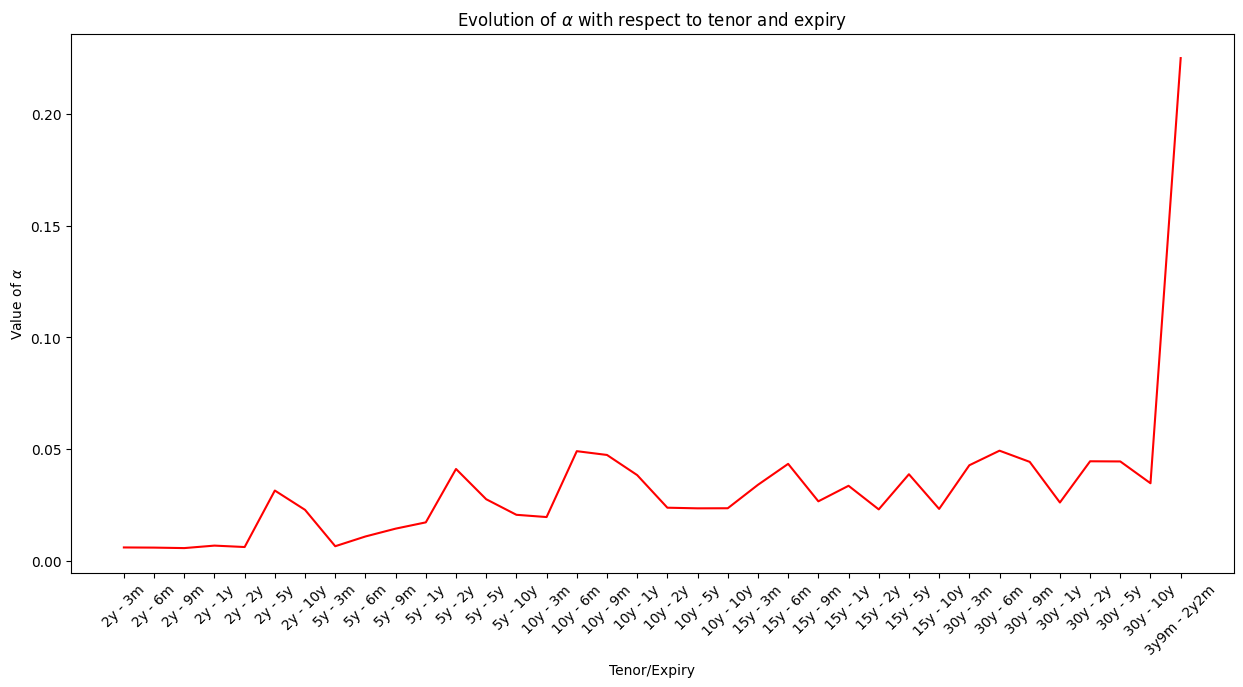

In [17]:
# Plot the evolution of alpha with respect to time
plt.figure(figsize=(15, 7))
_ = parameters["alpha"].plot(color="red", rot=45)
_ = plt.title(r"Evolution of $\alpha$ with respect to tenor and expiry")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"Value of $\alpha$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)

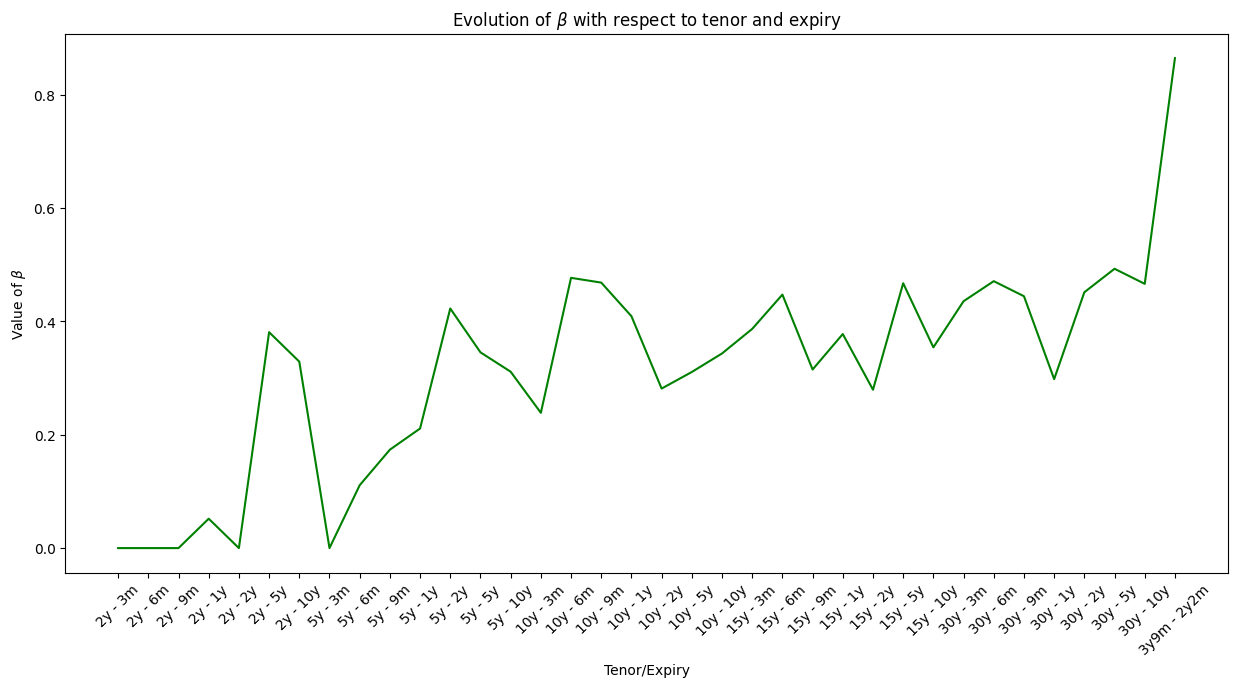

In [18]:
# Plot the evolution of beta with respect to time
plt.figure(figsize=(15, 7))
_ = parameters["beta"].plot(color="green", rot = 45)
_ = plt.title(r"Evolution of $\beta$ with respect to tenor and expiry")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"Value of $\beta$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)

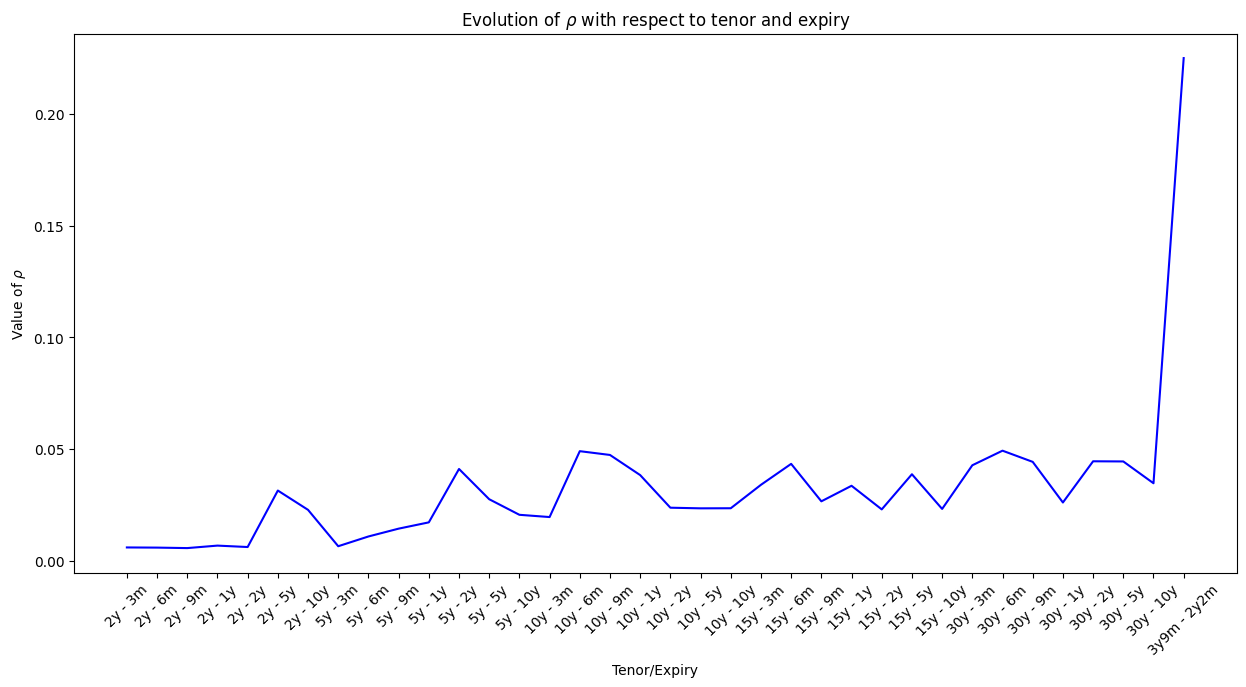

In [19]:
# Plot the evolution of rho with respect to time
plt.figure(figsize=(15, 7))
_ = parameters["alpha"].plot(color="blue", rot = 45)
_ = plt.title(r"Evolution of $\rho$ with respect to tenor and expiry")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"Value of $\rho$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)

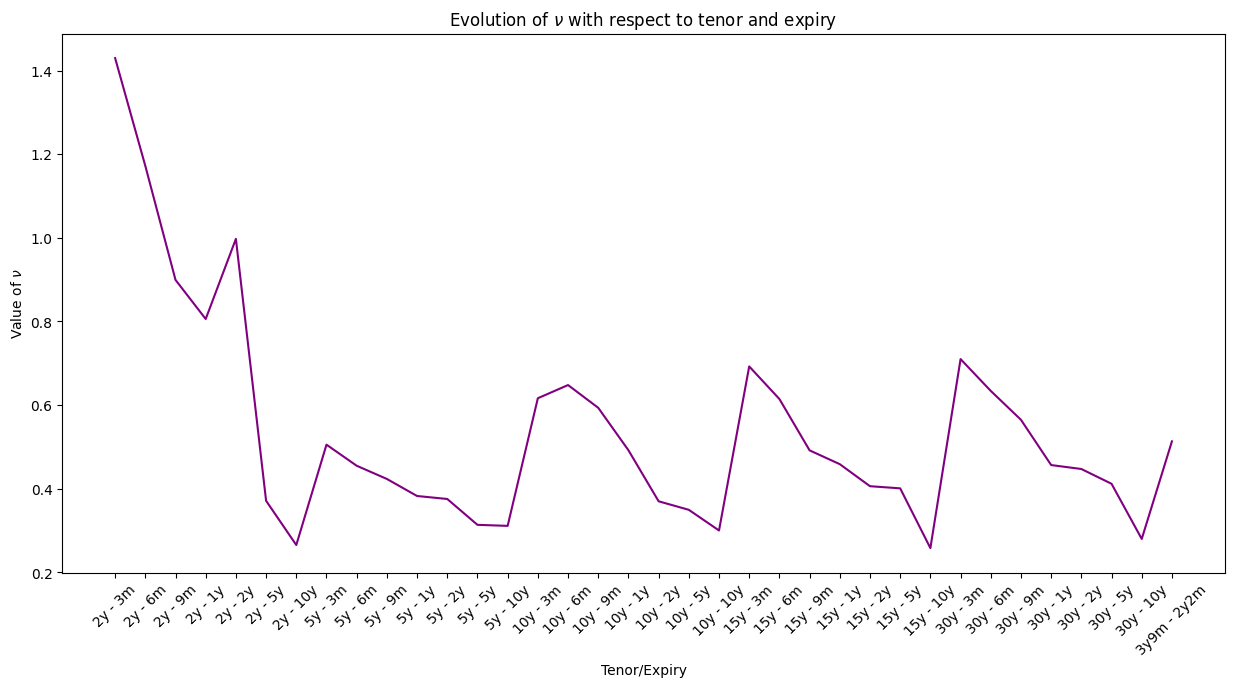

In [20]:
# Plot the evolution of nu with respect to time
plt.figure(figsize=(15, 7))
_ = parameters["nu"].plot(color="purple", rot = 45)
_ = plt.title(r"Evolution of $\nu$ with respect to tenor and expiry")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"Value of $\nu$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)

### Volatility with respect to various strike prices

We now want to plot the volatilities (SABR + MKT) with respect to time, for each strike price.

In [21]:
# Importing the volatilities from SABR model simulations (input data) and market data (output data)
VOL_SABR = pd.read_csv("outvol.csv", 
                       sep=";", 
                       header=0)
VOL_MKT = pd.read_excel('market_data.xlsx', 
                        header=1)

PARAMETERS = pd.read_csv("parameters.csv", 
                         sep=";", 
                         index_col=False)

# Strike spreads
STRIKES_SPREADS = [-150, -100, -50, -25, 0, 25, 50, 100, 150]

# Index increments
INCREMENTS = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

# Column indices for strikes
STRIKES_COLUMNS_RANGE_SABR = [2, 3, 4, 5, 6, 7, 8, 9, 10] # ATM = 6
STRIKES_COLUMNS_RANGE_MKT = [3, 4, 5, 6, 7, 8, 9, 10, 11] # ATM = 7

# Column index for ATM
ATM_SABR = 6
ATM_MKT = 7

First of all, we want to plot the SABR and market (MKT) volatilities over the consider time period of the given swaption.  

$\longrightarrow$ We are taking the example of the ATM case for each situation.

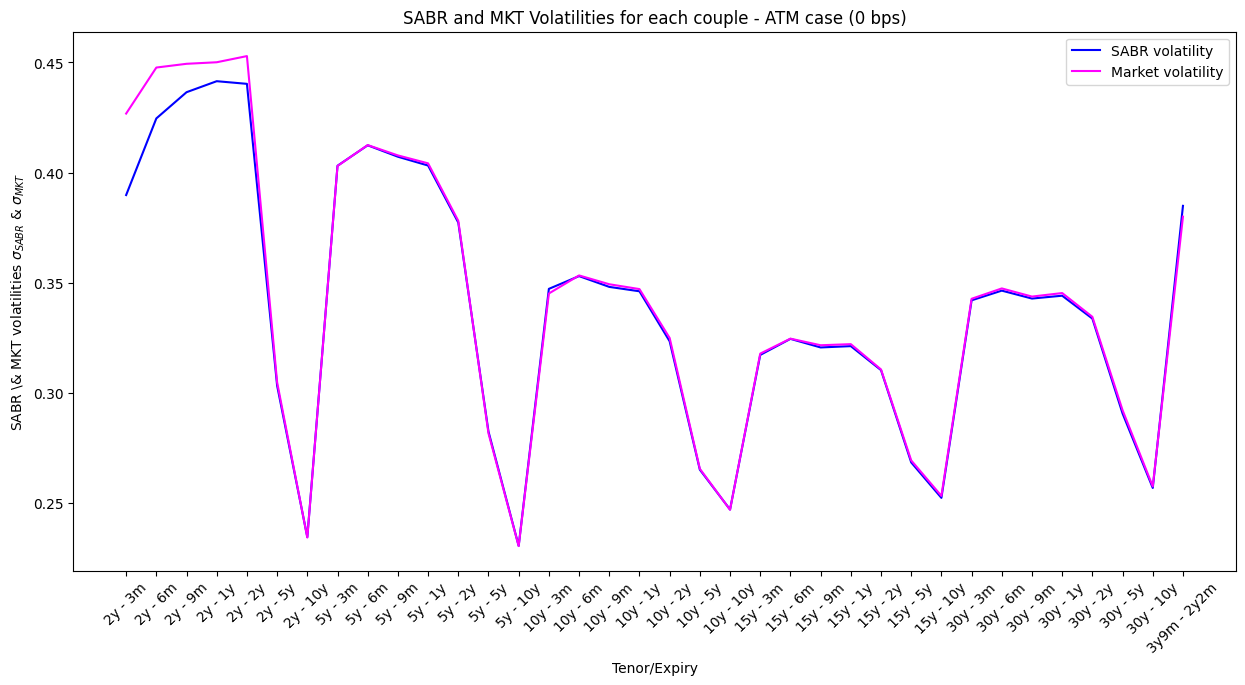

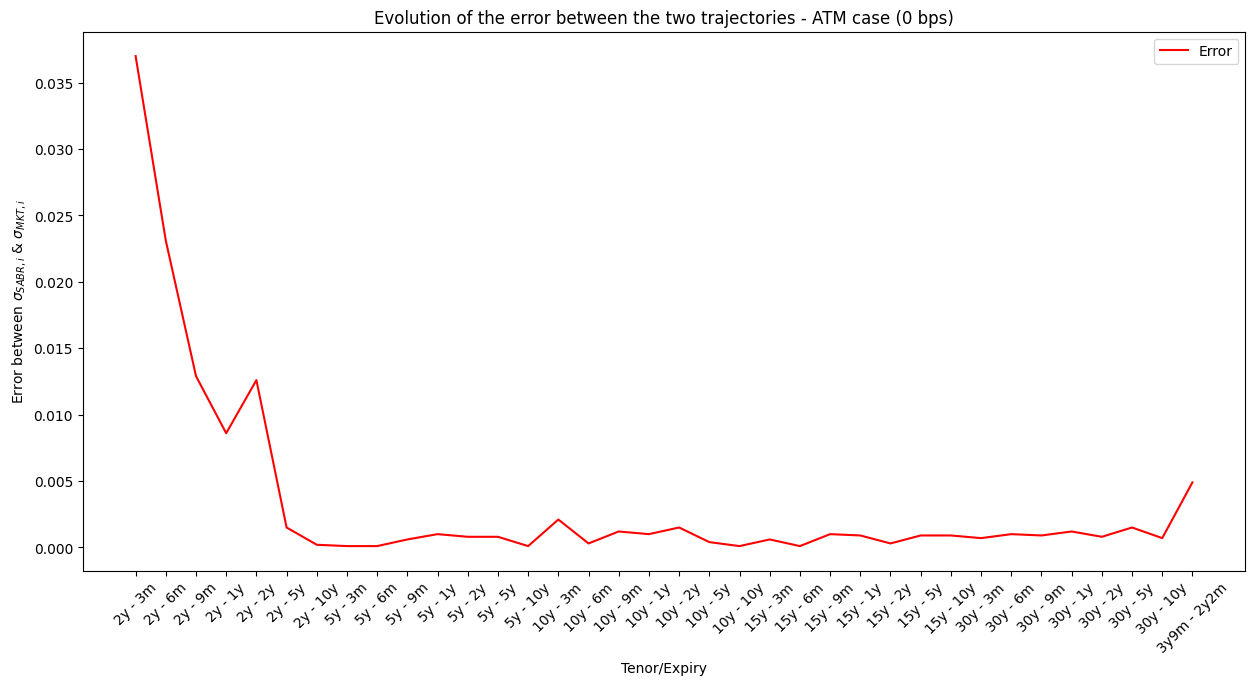

In [22]:
# Plotting the SABR & market volatilities (ATM)
plt.figure(figsize=(15, 7))
_ = VOL_SABR.iloc[:, ATM_SABR].plot(color="blue", rot = 45, label="SABR volatility")
_ = VOL_MKT.iloc[:, ATM_MKT].plot(color="magenta", rot = 45, label="Market volatility")
_ = plt.title(r"SABR and MKT Volatilities for each couple - ATM case (0 bps)")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"SABR \& MKT volatilities $\sigma_{SABR}$ & $\sigma_{MKT}$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)
_ = plt.legend(loc="upper right")

# Computing the absolute error between the two trajectories at ATM
ABSOLUTE_ERROR = abs(VOL_SABR.iloc[:, ATM_SABR] - VOL_MKT.iloc[:, ATM_MKT])

# Plotting the error (ATM)
plt.figure(figsize=(15, 7))
_ = ABSOLUTE_ERROR.plot(color="red", rot = 45, label="Error")
_ = plt.title(r"Evolution of the error between the two trajectories - ATM case (0 bps)")
_ = plt.xlabel("Tenor/Expiry")
_ = plt.ylabel(r"Error between $\sigma_{SABR, i}$ & $\sigma_{MKT, i}$")
_ = plt.xticks(INDEX_RANGE, INDEX_LABELS)
_ = plt.legend(loc="upper right")

For the other **bps** values of the strike spreads, 

$$(-150, -100, -50, -25, 0, +25, +50, +100, +150)$$

We will perform the same plotting procedure.

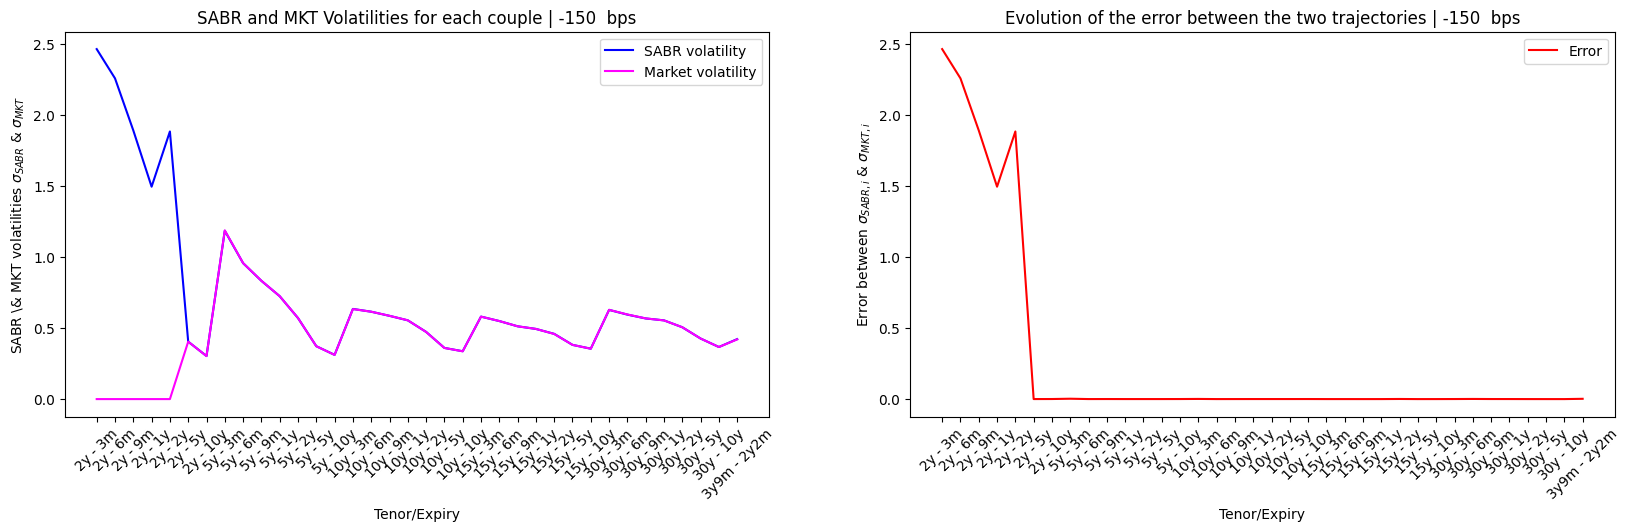

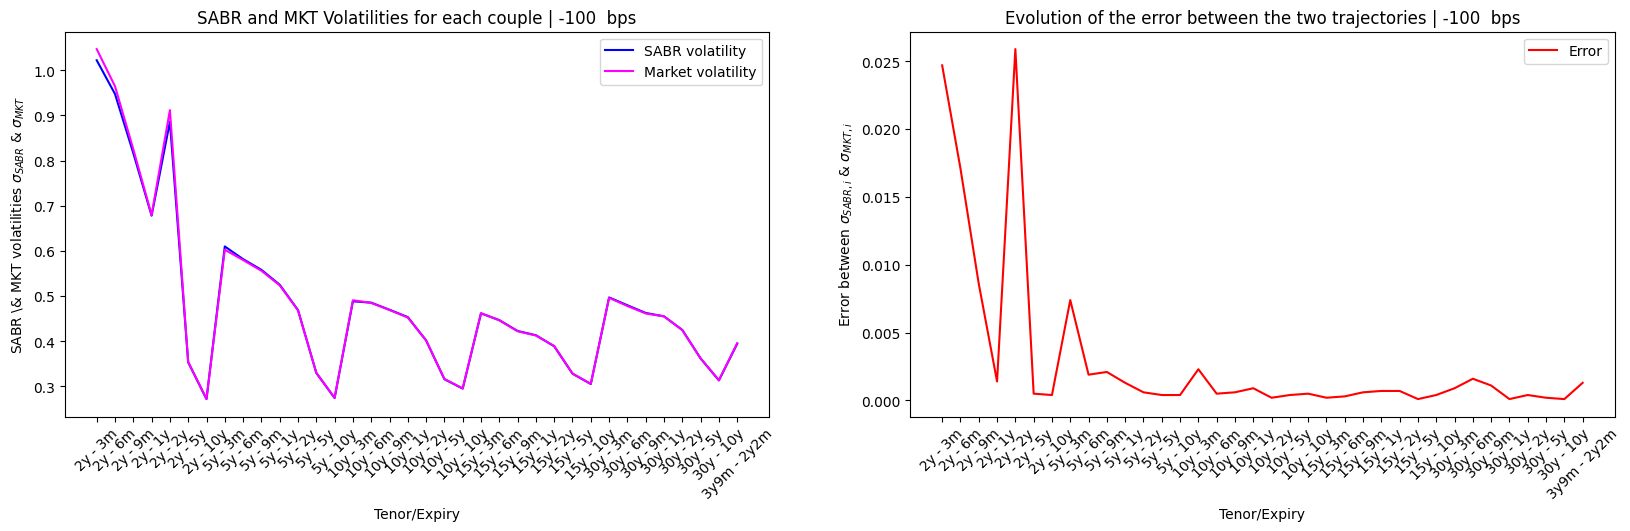

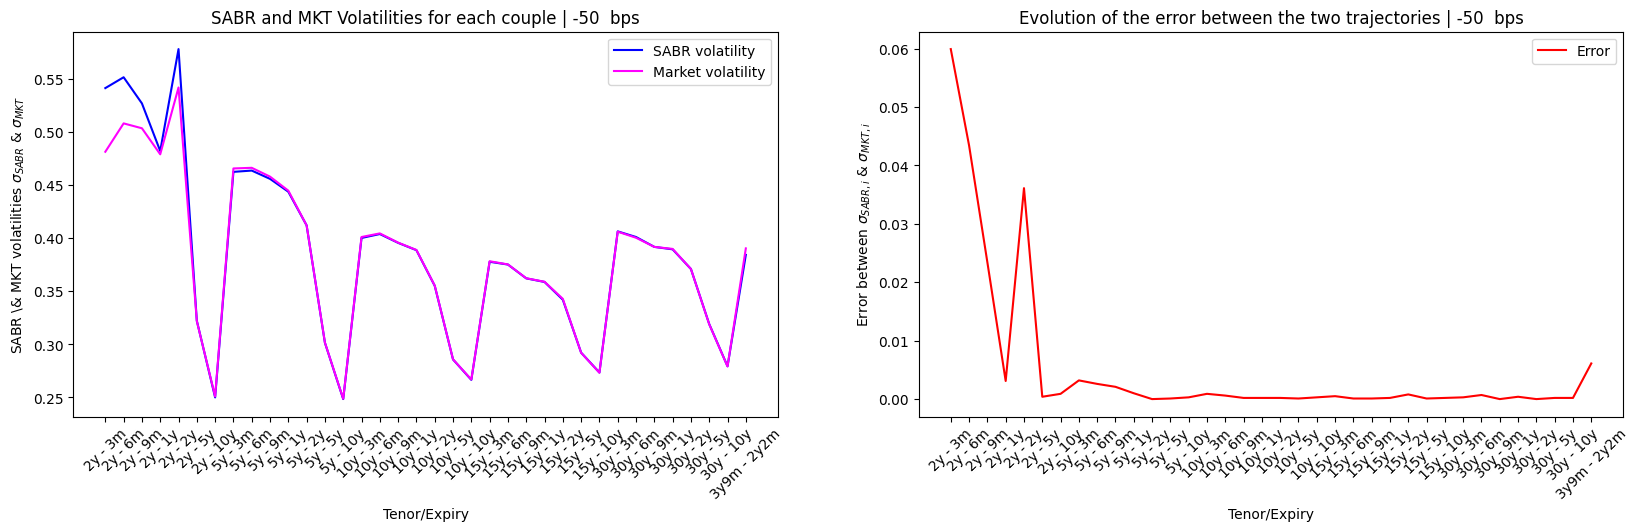

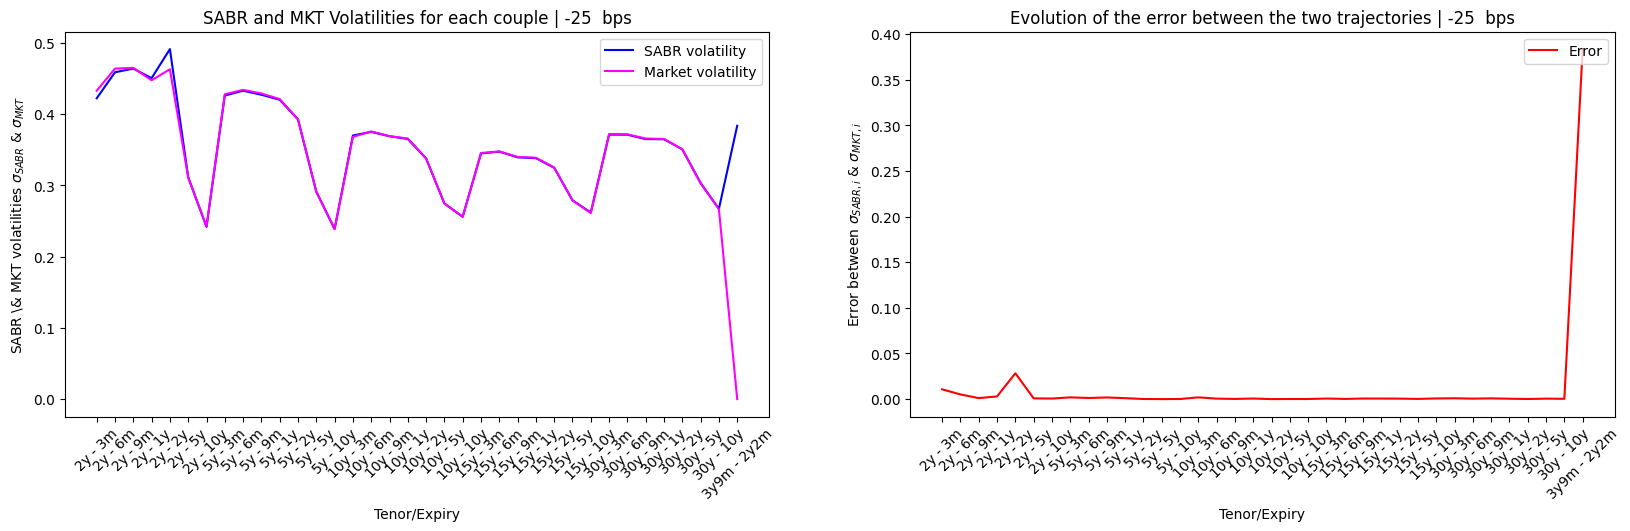

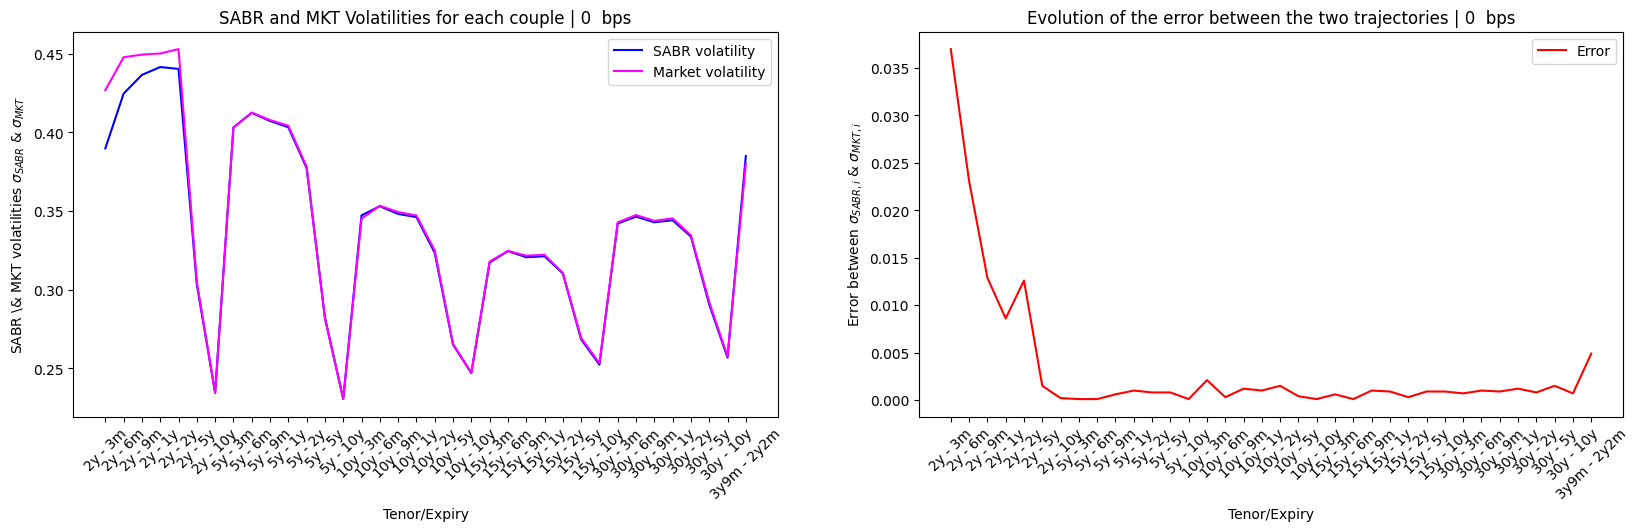

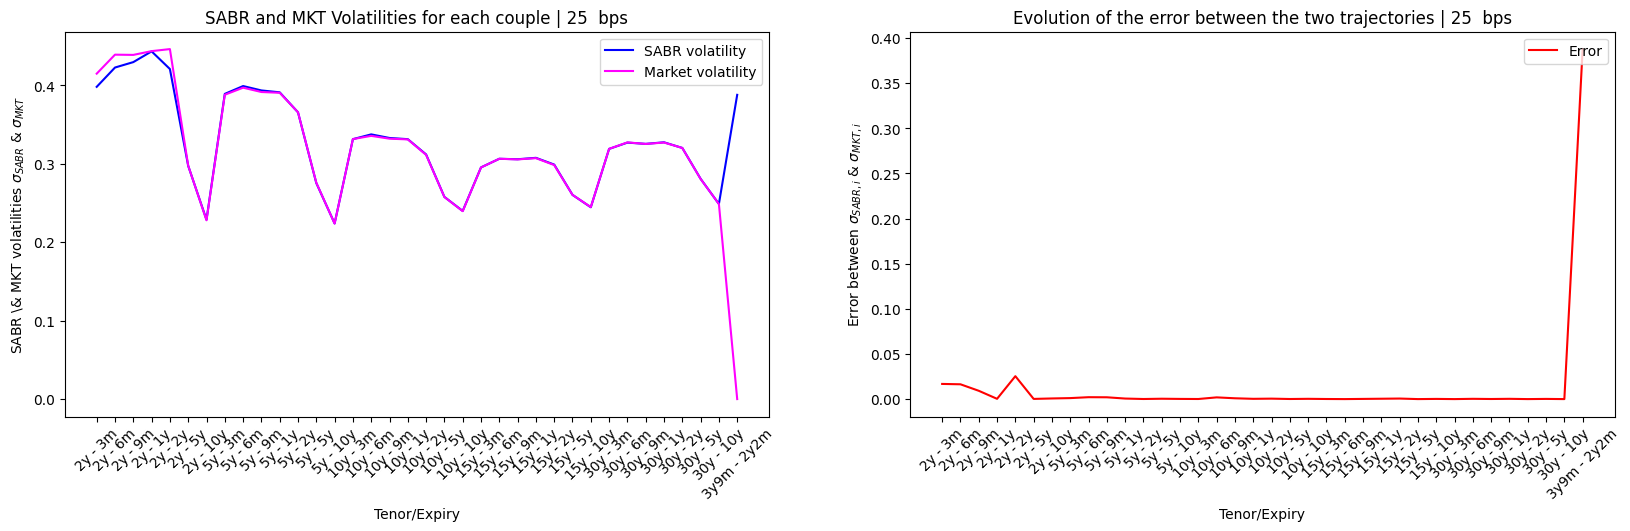

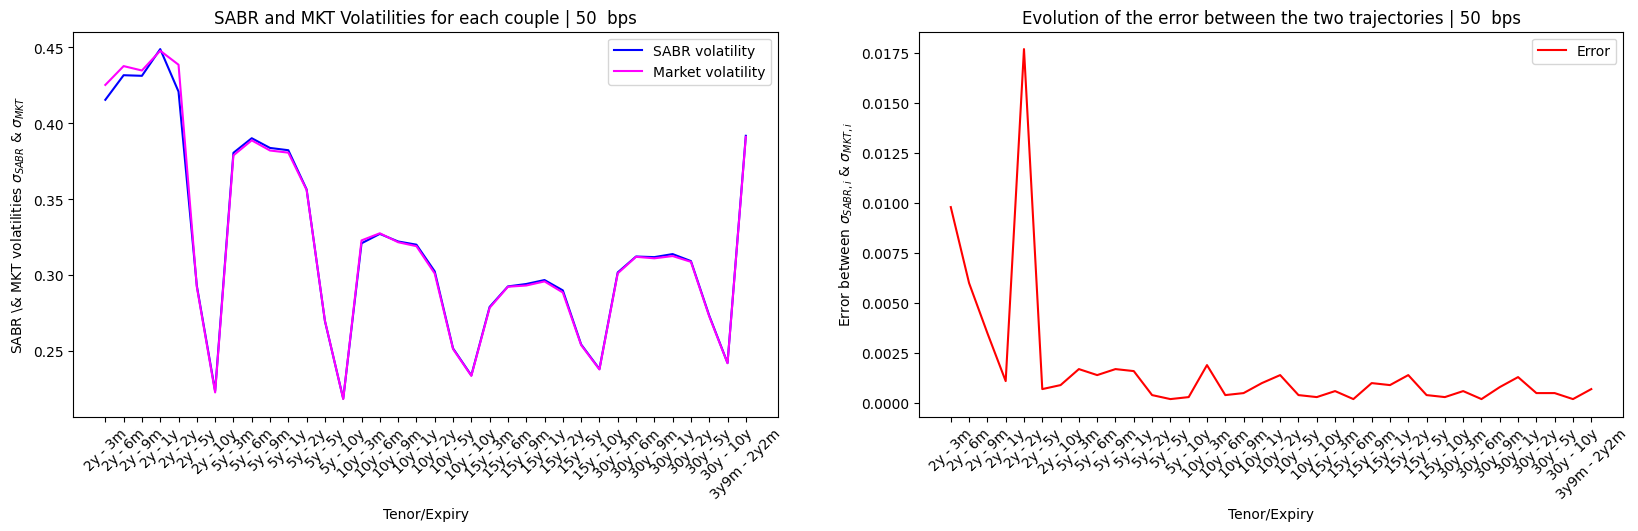

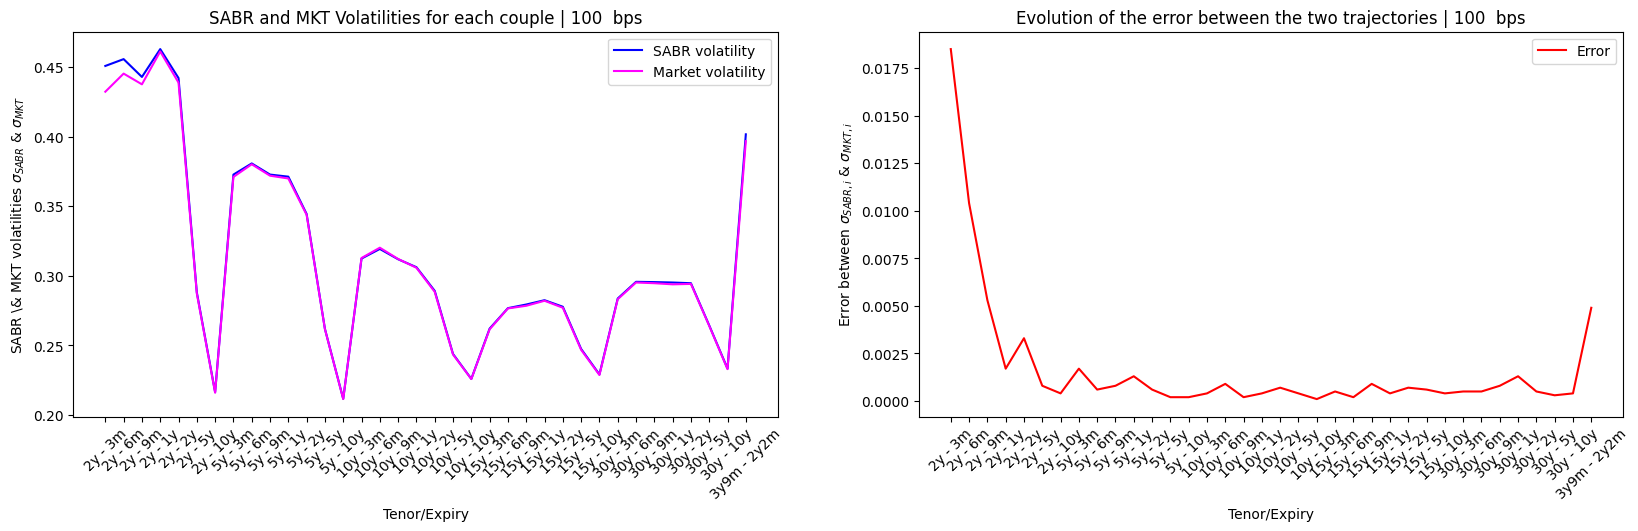

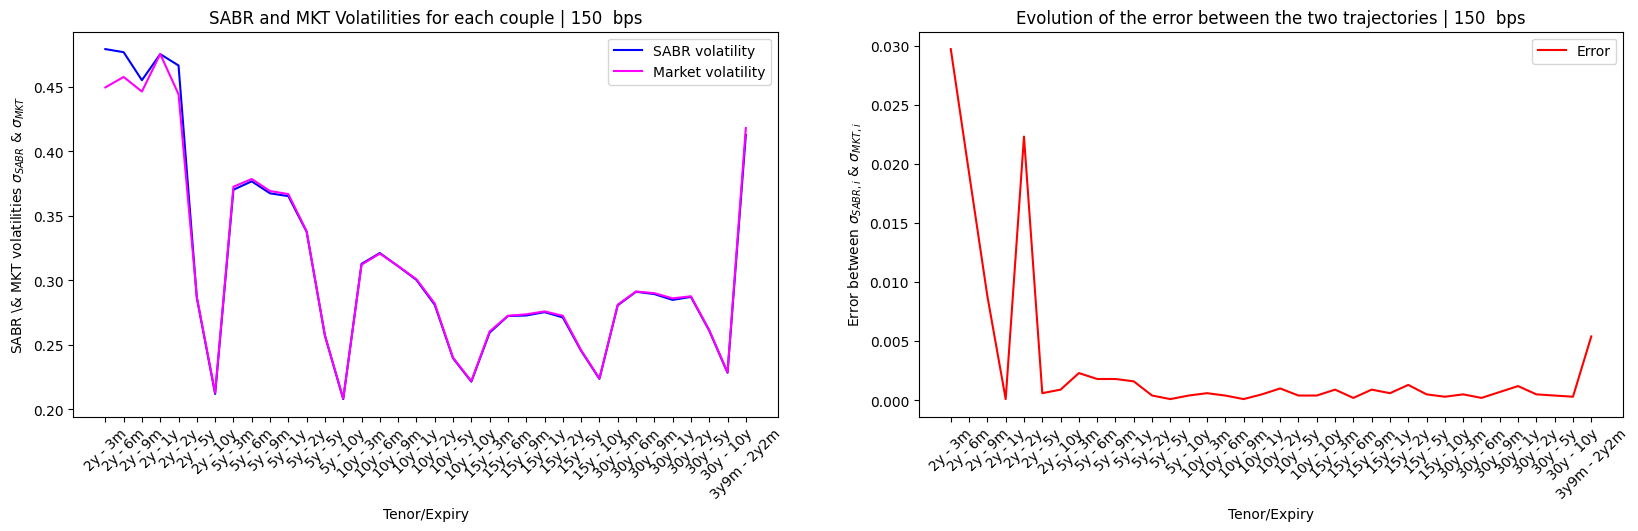

In [23]:
for inc in INCREMENTS:
    # Plotting the SABR & market volatilities
    bps = STRIKES_SPREADS[4 + inc]
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    _ = VOL_SABR.iloc[:, ATM_SABR + inc].plot(color="blue", rot = 45, label="SABR volatility")
    _ = VOL_MKT.iloc[:, ATM_MKT + inc].plot(color="magenta", rot = 45, label="Market volatility")
    _ = plt.title(f"SABR and MKT Volatilities for each couple | {bps}  bps")
    _ = plt.xlabel("Tenor/Expiry")
    _ = plt.ylabel(r"SABR \& MKT volatilities $\sigma_{SABR}$ & $\sigma_{MKT}$")
    _ = plt.xticks(INDEX_RANGE, INDEX_LABELS)
    _ = plt.legend(loc="upper right")

    # Computing the absolute error between the two trajectories
    ABSOLUTE_ERROR = abs(VOL_SABR.iloc[:, ATM_SABR + inc] - VOL_MKT.iloc[:, ATM_MKT + inc])

    # Plotting the error
    plt.subplot(1, 2, 2)
    _ = ABSOLUTE_ERROR.plot(color="red", rot = 45, label="Error")
    _ = plt.title(f"Evolution of the error between the two trajectories | {bps}  bps")
    _ = plt.xlabel("Tenor/Expiry")
    _ = plt.ylabel(r"Error between $\sigma_{SABR, i}$ & $\sigma_{MKT, i}$")
    _ = plt.xticks(INDEX_RANGE, INDEX_LABELS)
    _ = plt.legend(loc="upper right")

### SABR implied volatility smiles

We finally want to plot the implied volatility smiles obtained using the SABR model, and compare them to the market volatility smiles.

$\longrightarrow$ We will perform the same protocol for each couple tenor/expiry.

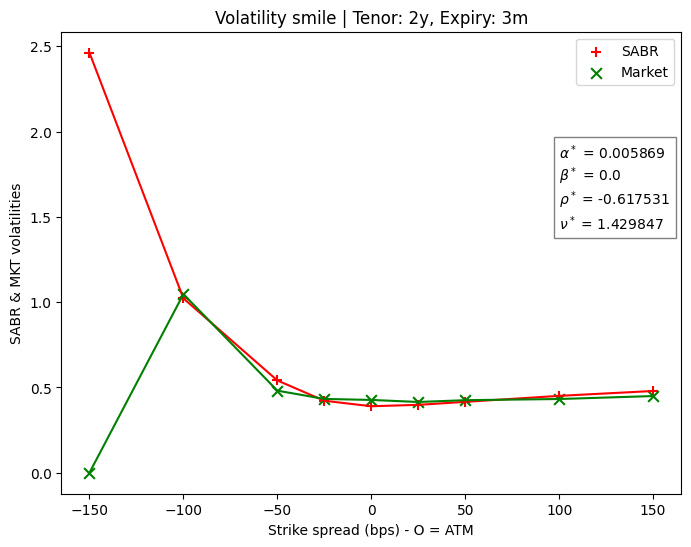

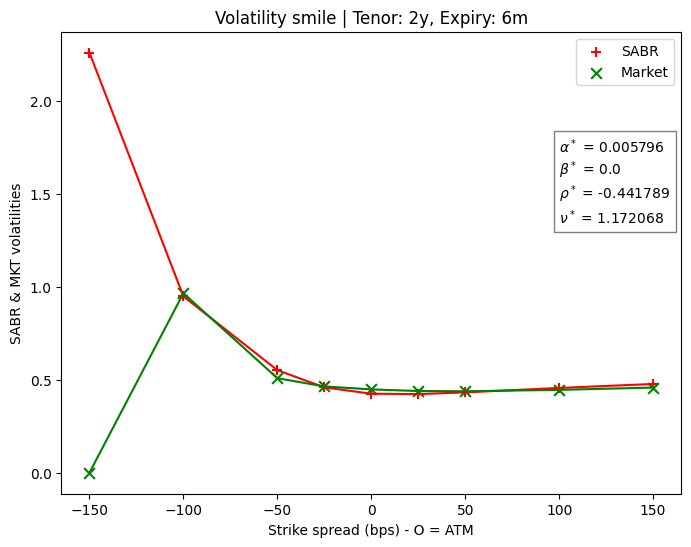

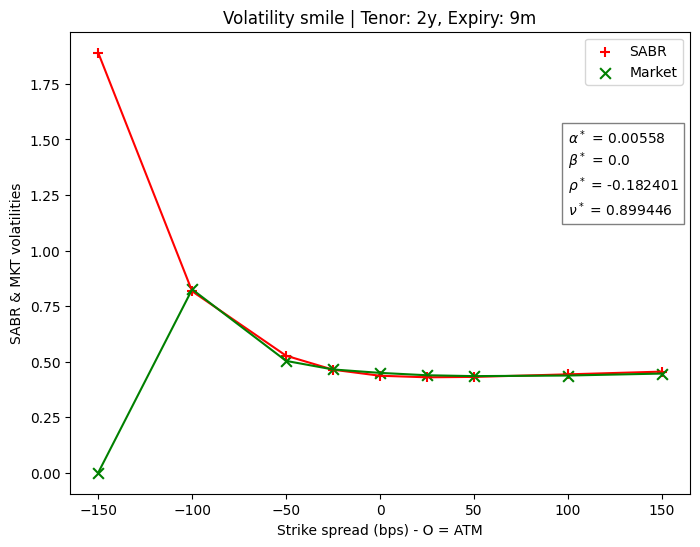

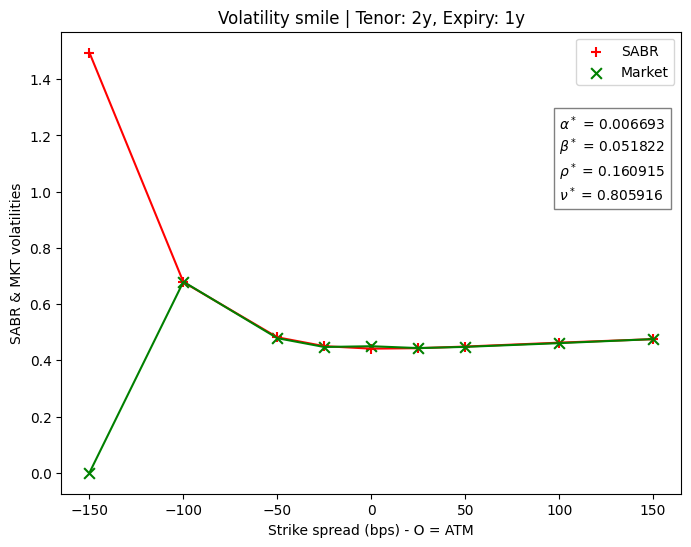

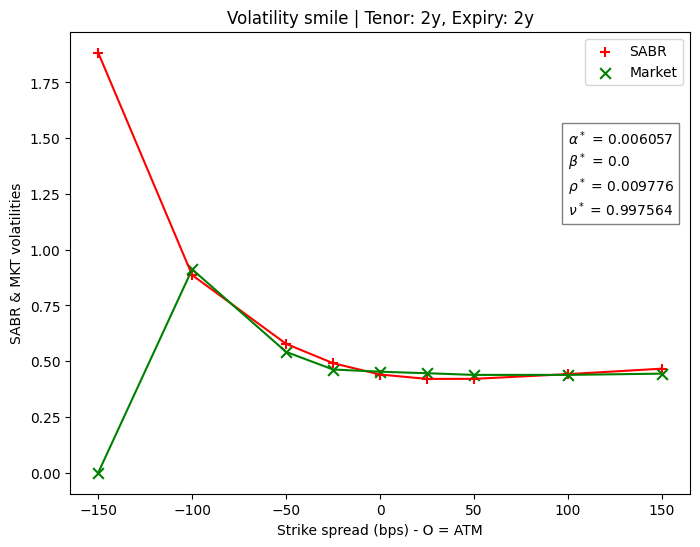

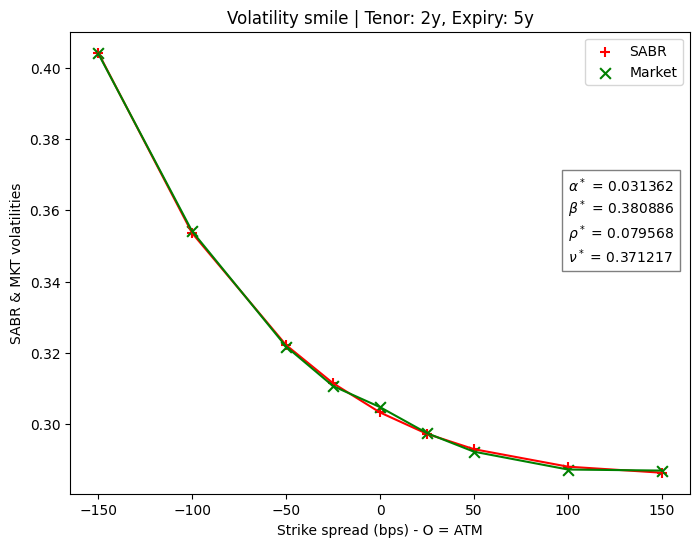

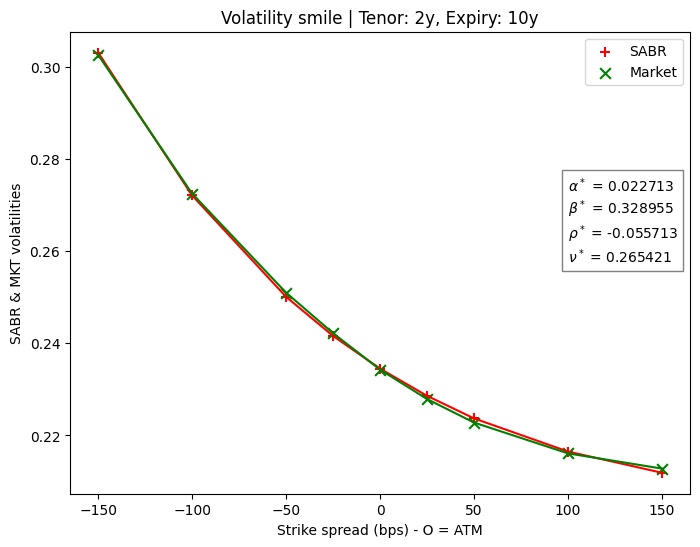

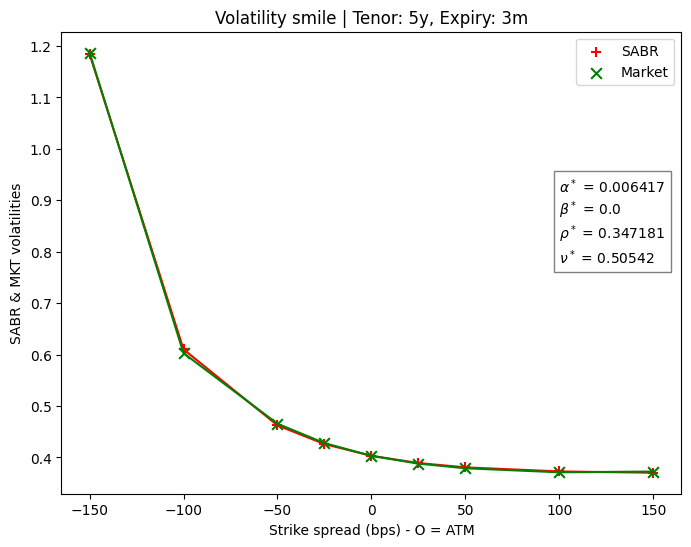

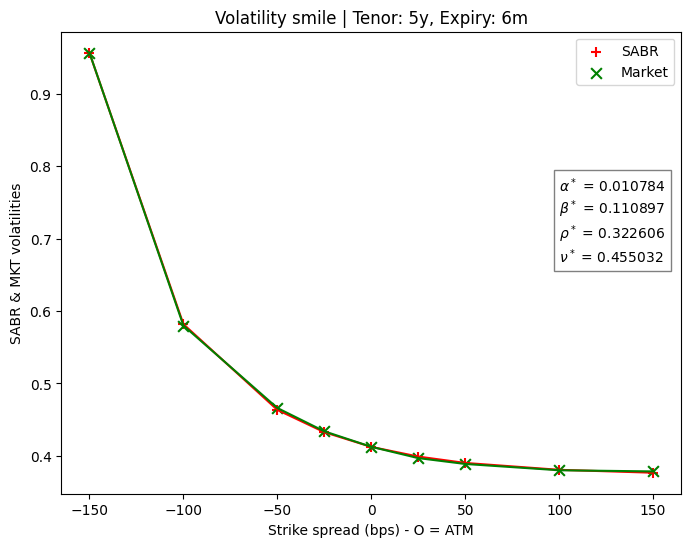

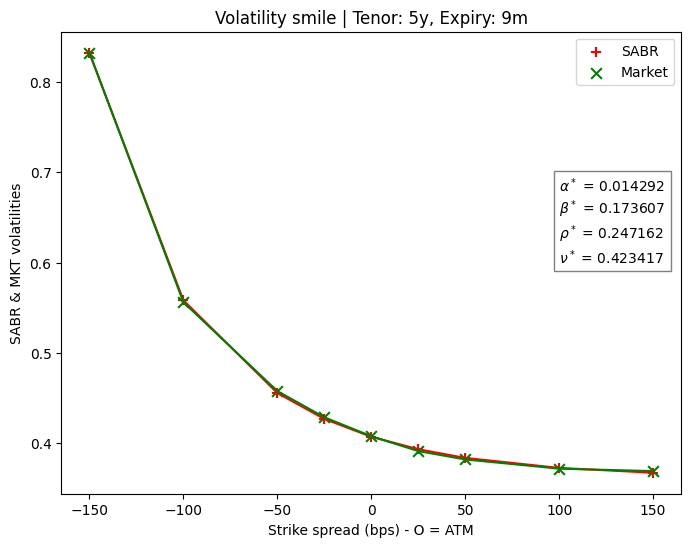

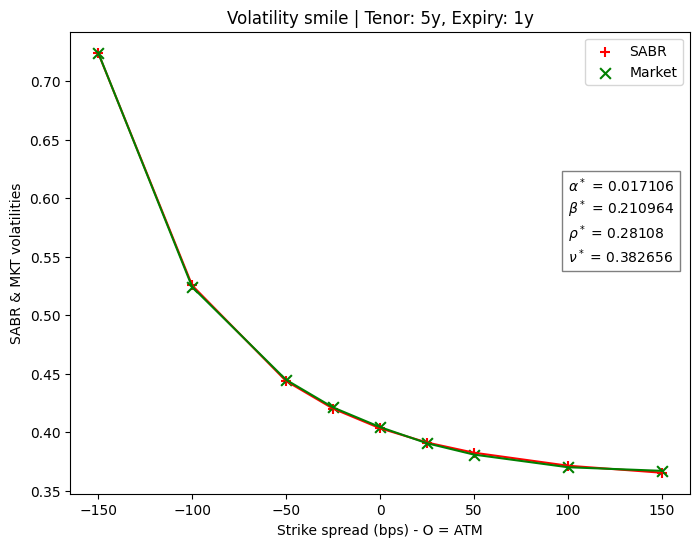

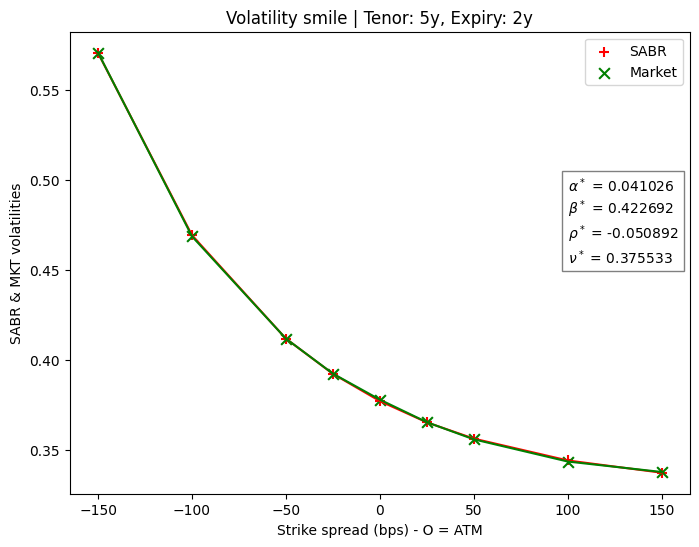

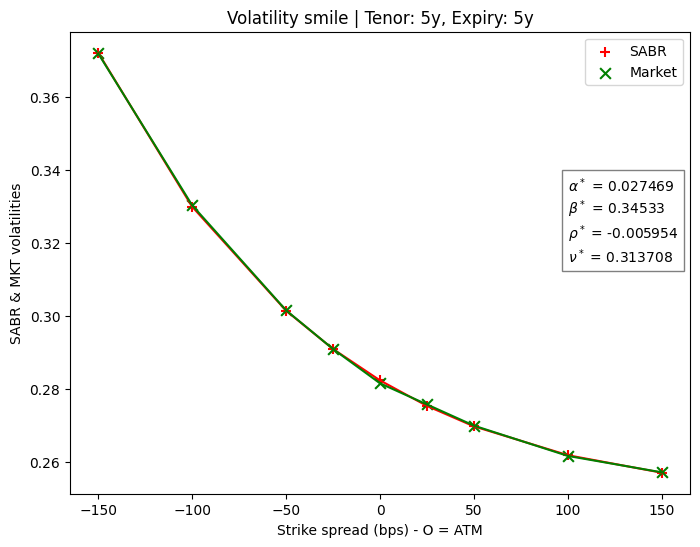

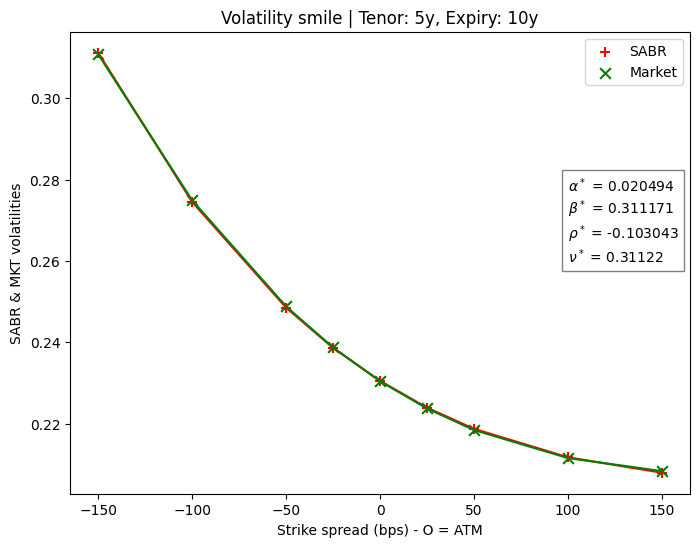

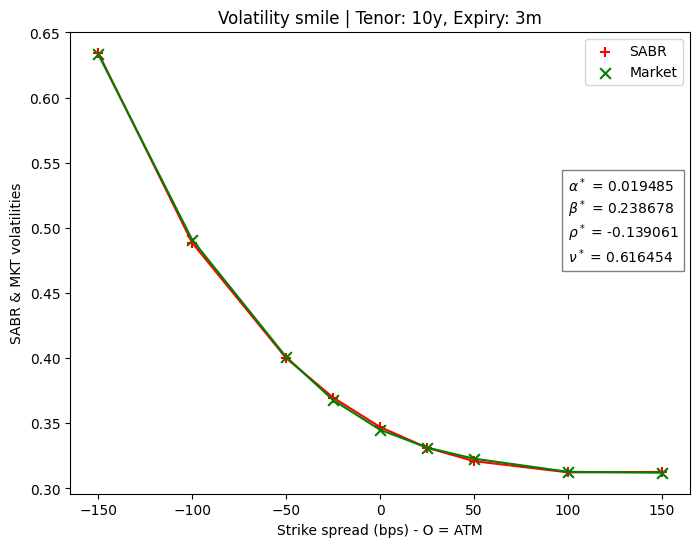

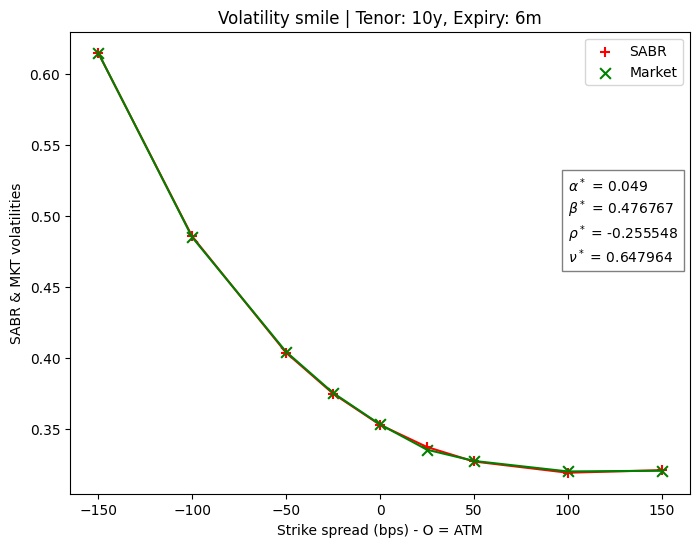

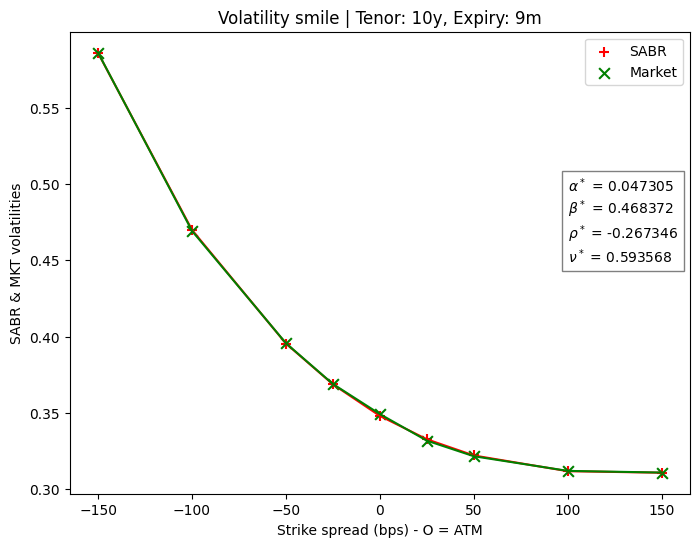

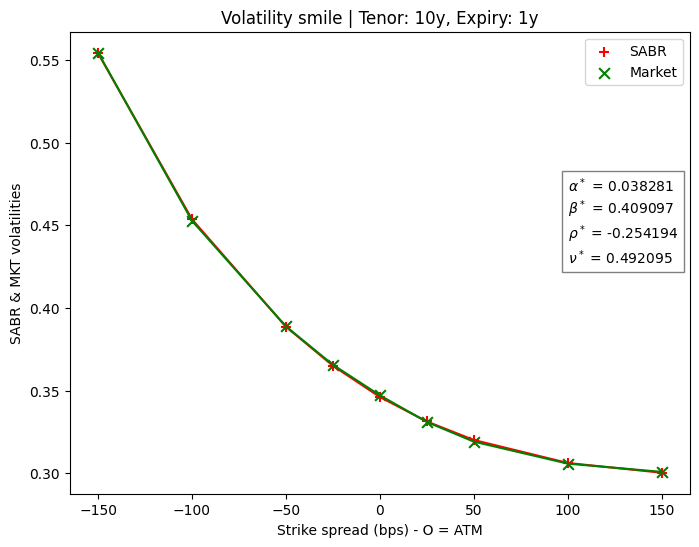

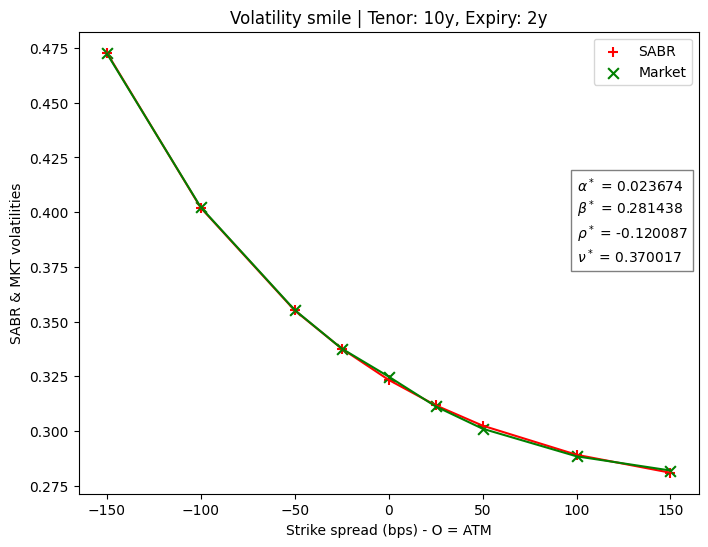

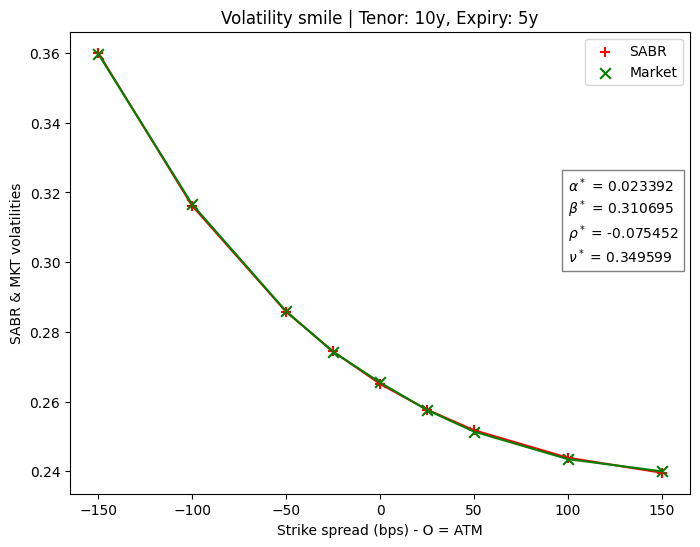

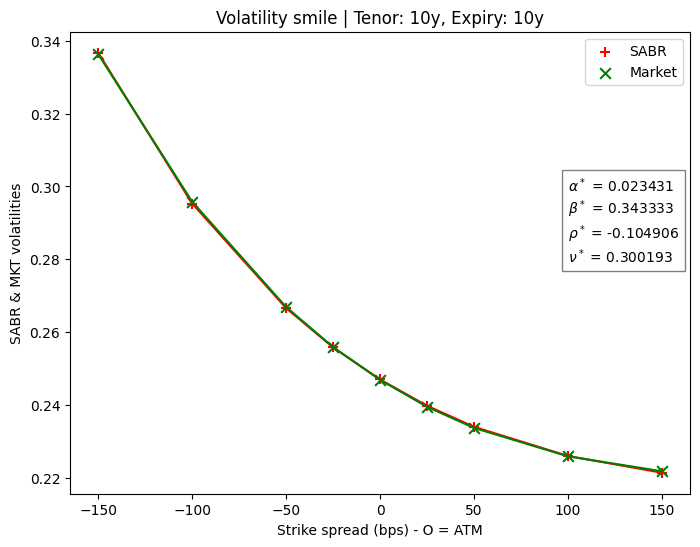

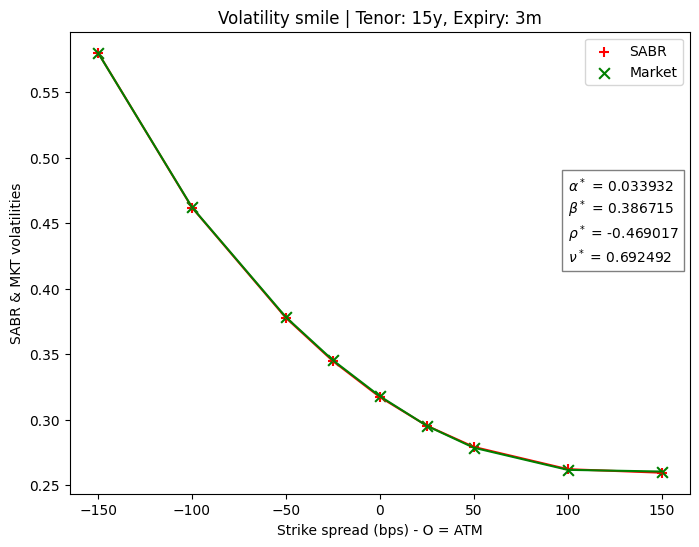

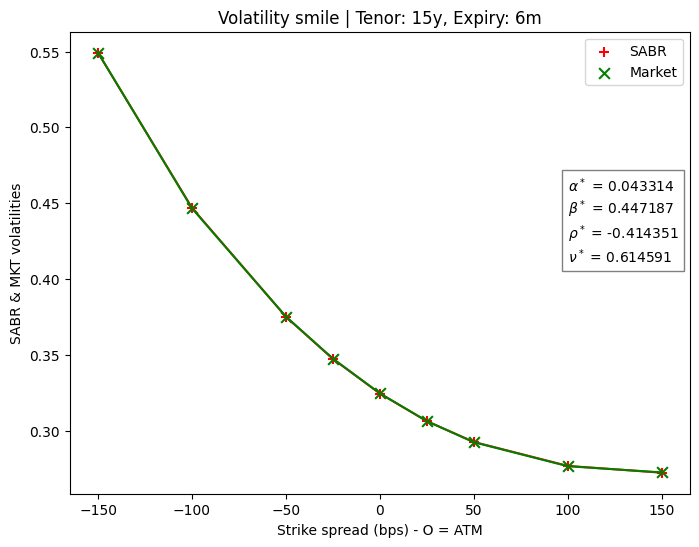

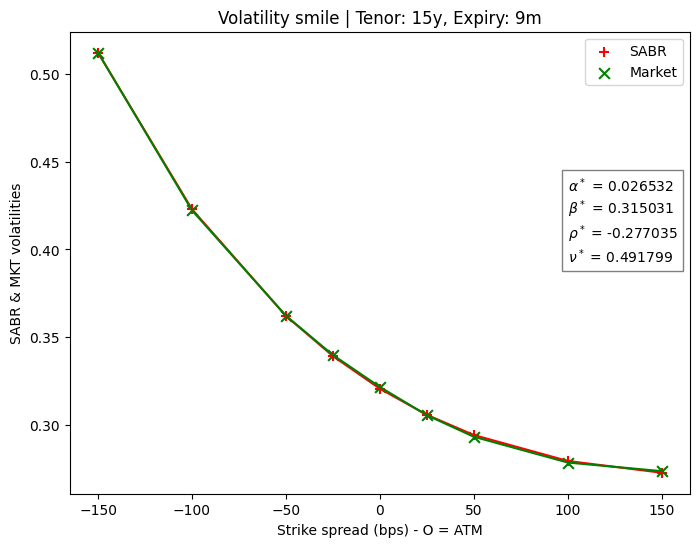

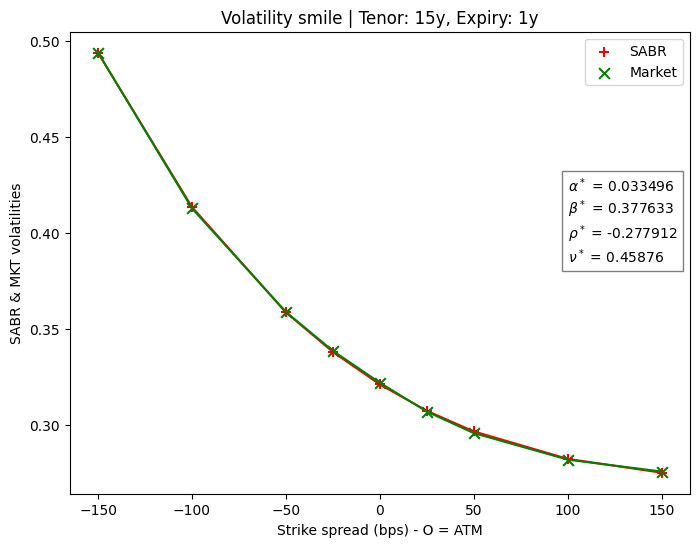

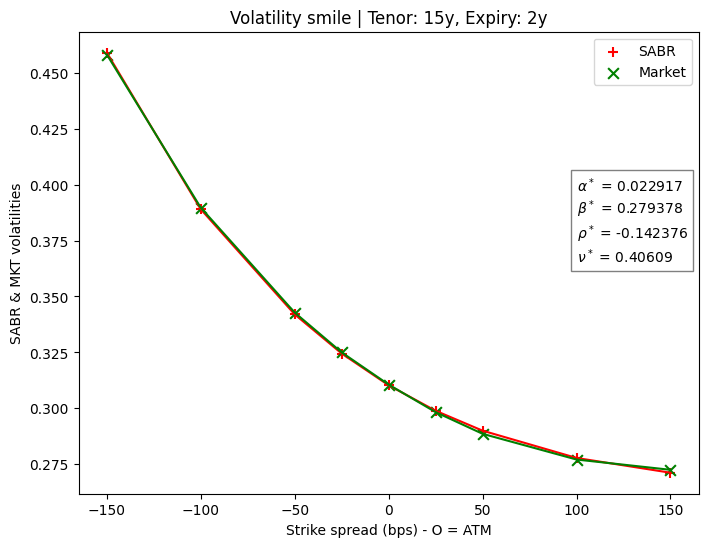

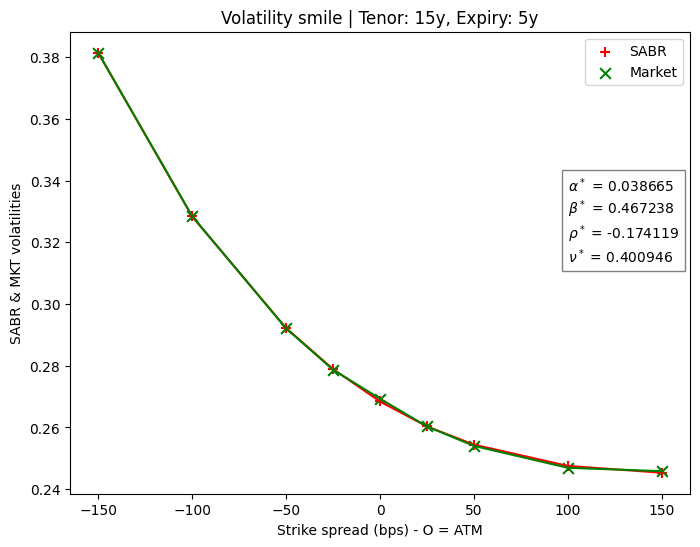

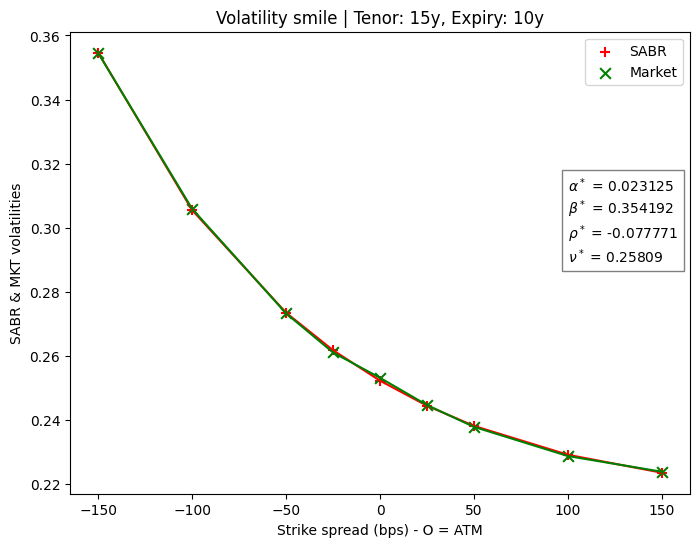

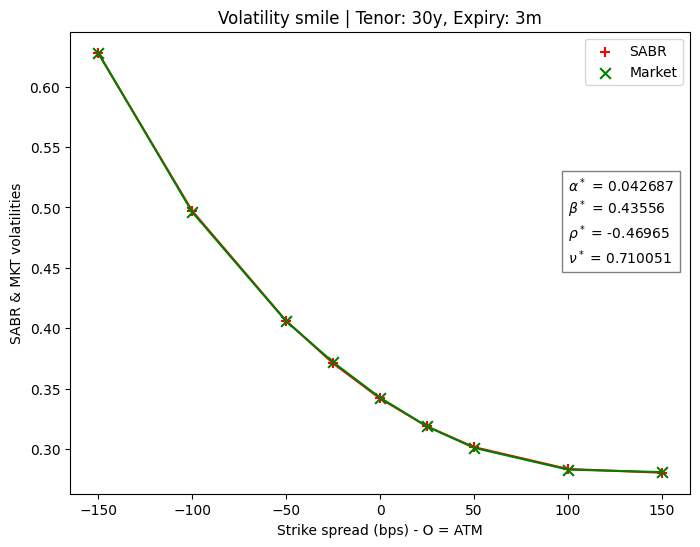

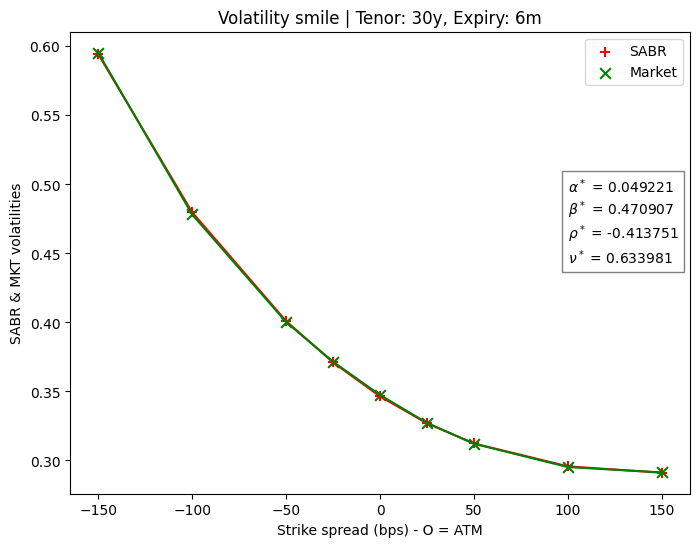

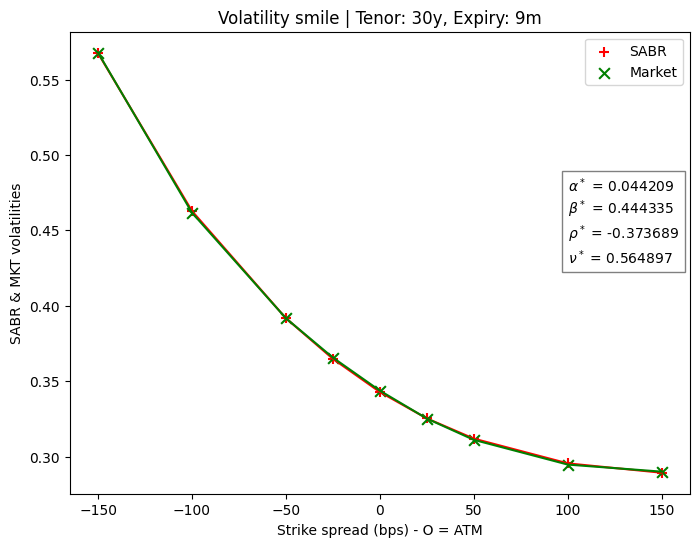

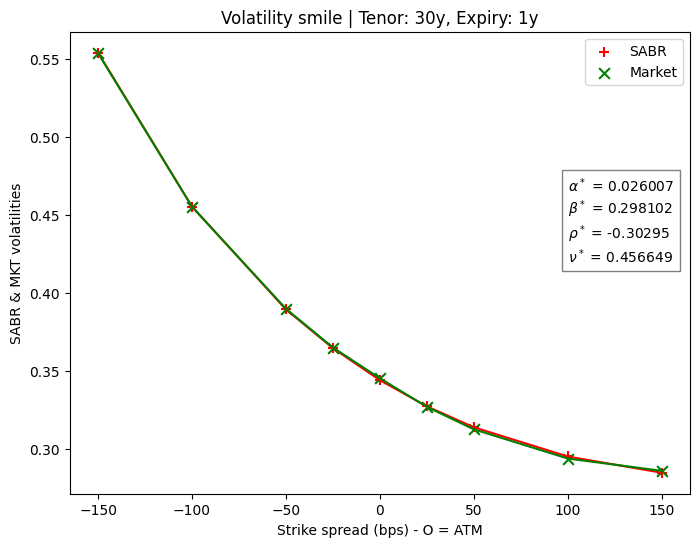

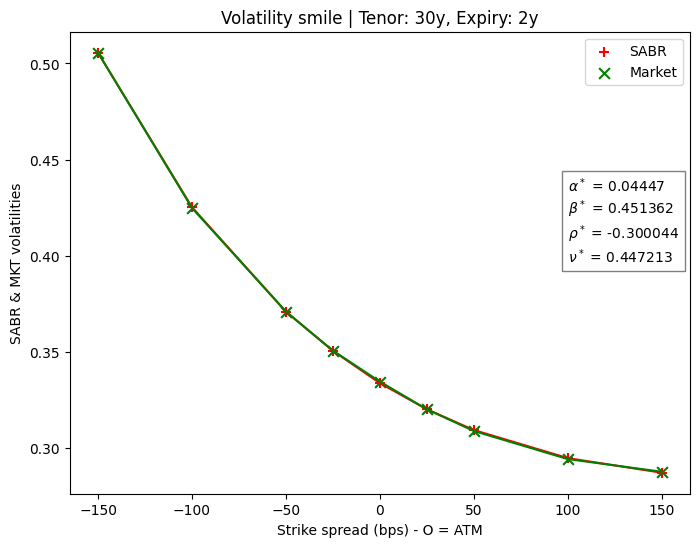

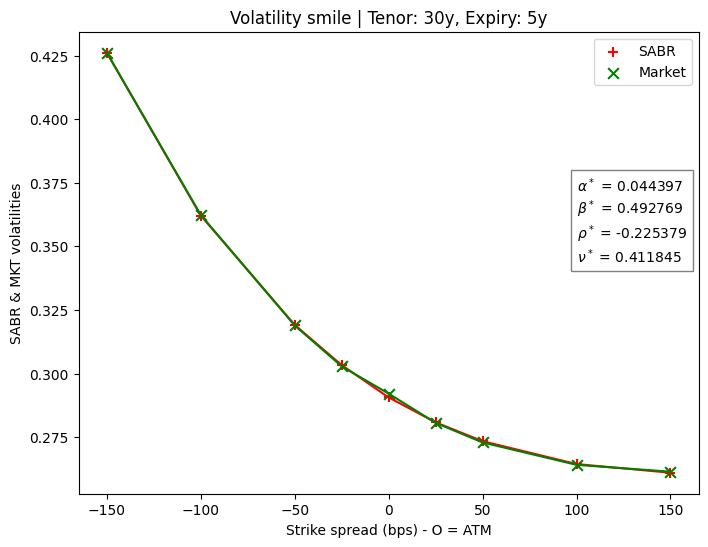

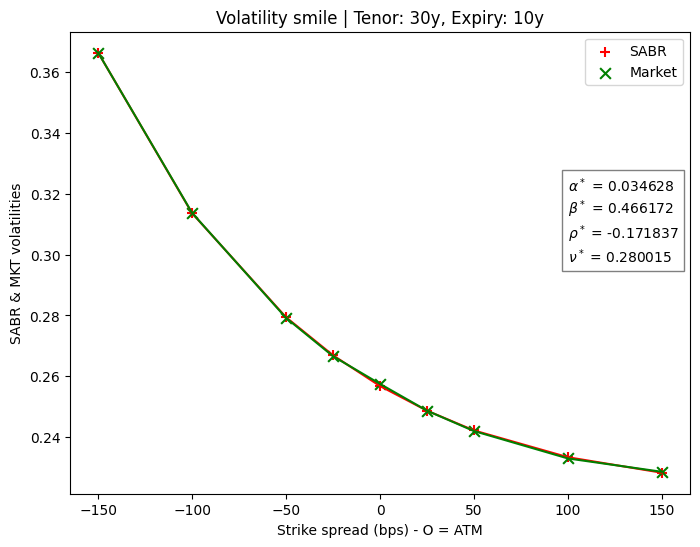

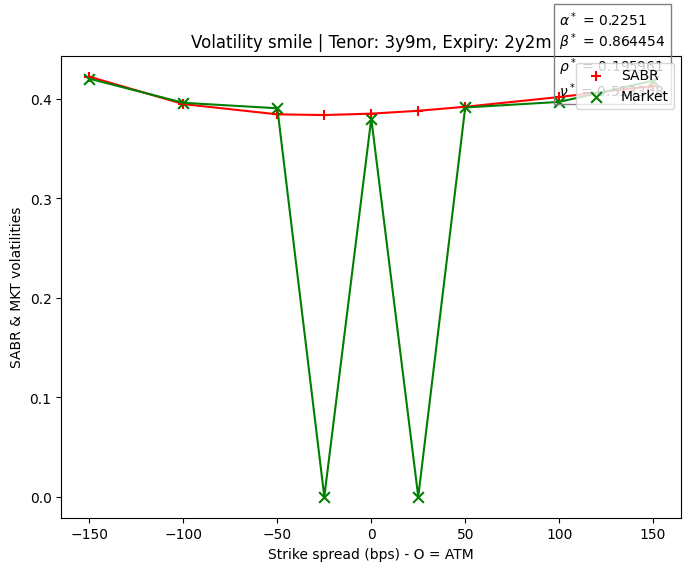

In [24]:
i = 0
for couple in INDEX:
    #print(couple, "\t\t", i)
    
    # Collecting the SABR volatilies for each couple
    VOL_COUPLE_SABR = VOL_SABR.iloc[i,2:11]
    VOL_COUPLE_MKT = VOL_MKT.iloc[i,3:12]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(STRIKES_SPREADS, VOL_COUPLE_SABR, color="red", marker="+", s = 60, label="SABR")
    plt.scatter(STRIKES_SPREADS, VOL_COUPLE_MKT, color="green", marker="x", s = 60, label="Market")
    plt.title(f"Volatility smile | Tenor: {couple[0]}, Expiry: {couple[1]}")
    plt.xlabel("Strike spread (bps) - O = ATM")
    plt.ylabel("SABR & MKT volatilities")
    plt.legend(loc="upper right")
    
    # Interpolation
    f1 = interp1d(x = STRIKES_SPREADS, 
                  y= VOL_COUPLE_SABR,
                  kind = "cubic")
    f2 = interp1d(x = STRIKES_SPREADS, 
                  y= VOL_COUPLE_MKT,
                  kind = "cubic")
    plt.plot(STRIKES_SPREADS, f1(STRIKES_SPREADS), color="red")
    plt.plot(STRIKES_SPREADS, f2(STRIKES_SPREADS), color="green")
    
    
    y = (max(VOL_COUPLE_SABR) + min(VOL_COUPLE_SABR))/2
    
    # Collecting the optimized coefficients alpha, beta, rho, nu for each couple
    alpha, beta, rho, nu = parameters.iloc[i, :]
    #print(alpha, beta, rho, nu)
    
    annotation = fr"$\alpha^*$ = {alpha}"
    annotation += "\n"
    annotation += fr"$\beta^*$ = {beta}"
    annotation += "\n"
    annotation += fr"$\rho^*$ = {rho}"
    annotation += "\n"
    annotation += fr"$\nu^*$ = {nu}"
    plt.text(x = 100,
             y = y, 
             s = annotation, 
             bbox = dict(facecolor="none", edgecolor="gray"))
    
    
    
    # Incrementing
    i += 1

## Study of the impact of the parameters

### Introduction

In this first part, we have calibrated the model in order to find correct values of the SABR parameters. Thanks to them, we have successfully estimated the volatility and compared it to the market data.

---

We now want to study and enlight the impact of the different SABR parameters. By that, we want to know what is the impact on the shape of the implicit volatility smiles.




<p style="color:purple">
    <b><u>Adopted strategy</u></b>: In order to successfully conduct this study, we will point out the impact of a parameter at a time.
     <br><br>
    To study the impact of a given parameter, we fix the three other ones to constant values; we have chosen different values for each fixed parameter (see below).
     <br><br>
    We then estimate the resulting volatilities by adopting the same approach as above and we write on disk the results. Finally, we plot the different smiles for each respective parameter value on the same plot to conclude.
</p>

$\longrightarrow$ We are using the next parameter values in order to study the impact of the SABR parameters $\alpha$, $\beta$, $\rho$ and $\mu$:

In [93]:
# Parameter values to be evaluated
ALPHA = [0.15, 0.2, 0.25]
BETA = [0.2, 0.25, 0.5, 0.75, 1]
RHO = [-0.75, -0.5, 0, 0.5, 0.75]
NU = [0.5, 0.7, 0.9, 1.2]

# When other values are fixed, we use the following ones
FIXED_VALUES = {
    "ALPHA": 0.2,
    "BETA": 1,
    "RHO": -0.6,
    "NU": 1.2
}

### Pre-processing

In [94]:
def study_parameter(f, p1, p2, p3, p4):    
    print(f"Simulation for {f} \t: alpha = {p1}, beta = {p2}, rho = {p3}, nu = {p4}")
    
    # Loading input file = market data
    INPUTFILE_NAME = "market_data.xlsx"
    SHEET_NAME = "Swaptions data"
    while True:
        try:
            #file_input = pd.read_excel(io=INPUTFILE_NAME, sheet_name=SHEET_NAME, header=True)
            file_input = xlrd.open_workbook("MAIN.xls")     # load market data
        except Exception as e:
            print(f'Input file is not in the directory! : {e}')
        break

    # Switching to the given sheet
    Market_data = file_input.sheet_by_name('Swaptions data')        # file input forward rates

    # Setting swaptions characteristics
    strike_spreads = []
    j = 0

    while True:
        try:
            strike_spreads.append(int(Market_data.cell(1,3+j).value))
            j = j+1
        except:
            break
    num_strikes = len(strike_spreads)

    expiries=[]
    i=0
    while True:
            try:
                expiries.append(Market_data.cell(2+i,1).value)
                i = i + 1
            except:
                break

    tenors=[]
    i=0
    while True:
        try:
            tenors.append(Market_data.cell(2+i,0).value)
            i = i + 1
        except:
            break


    # to create the ATM forward rates
    F = []
    i=0
    while True:
        try:
            F.append(Market_data.cell(2+i,2).value)
            i = i+1
        except:
            break

    # to create the strike grid
    K = numpy.zeros((len(F),num_strikes))
    for i in range(len(F)):
        for j in range(num_strikes):
            K[i][j] = F[i] + 0.0001*(strike_spreads[j])  

    # to create market volatilities            
    MKT = numpy.zeros((len(F),num_strikes))
    for i in range(len(F)):
        for j in range(num_strikes):
            MKT[i][j] = Market_data.cell(2+i,3+j).value


    # set starting parameters
    starting_guess = numpy.array([0.001,0.5,0,0.001]) # x_0
    alpha = len(F)*[starting_guess[0]]
    beta = len(F)*[starting_guess[1]]
    rho = len(F)*[starting_guess[2]]
    nu = len(F)*[starting_guess[3]]
    
    # Setting labels
    exp_dates = len(expiries)*[0]
    for i in range(len(expiries)):
        if expiries[i] < 1:
            exp_dates[i] = str(int(round(12*expiries[i])))+'m'
        else:
            exp_dates[i] = str(int(round(expiries[i])))+'y'
            if expiries[i]-round(expiries[i]) > 0:
                exp_dates[i] = exp_dates[i]+str(int(round((12*(round(expiries[i],2)-int(expiries[i]))))))+'m' 
            elif expiries[i]-round(expiries[i]) < 0:
                exp_dates[i] = str(int(round(tenors[i]))-1)+'y'
                exp_dates[i] = exp_dates[i]+str(int(round((12*(round(expiries[i],2)-int(expiries[i]))))))+'m'

    ten_dates = len(tenors)*[0]
    for i in range(len(tenors)):
        if tenors[i] < 1:
            ten_dates[i] = str(int(round(12*tenors[i])))+'m'
        else:
            ten_dates[i] = str(int(round(tenors[i])))+'y'
            if tenors[i]-round(tenors[i]) > 0:
                ten_dates[i] = ten_dates[i]+str(int(round((12*(round(tenors[i],2)-int(tenors[i]))))))+'m' 
            elif tenors[i]-round(tenors[i]) < 0:
                ten_dates[i] = str(int(round(tenors[i]))-1)+'y'
                ten_dates[i] = ten_dates[i]+str(int(round((12*(round(tenors[i],2)-int(tenors[i]))))))+'m'

    label_exp = exp_dates
    label_ten = ten_dates
    label_strikes = num_strikes*[0]
    for i in range(num_strikes):
        if strike_spreads[i] == 0 :
            label_strikes[i] = 'ATM'
        else:
            label_strikes[i] = str(strike_spreads[i])
       
    # Used to study the impact of parameters on the implied volatility smile
    alpha = [p1] * len(F)
    beta = [p2] * len(F)
    rho = [p3] * len(F)
    nu = [p4] * len(F)
    SABR_vol_matrix(alpha,beta,rho,nu,F,K,expiries,MKT)    

### Impact of $\alpha$

In [95]:
# Creating the intermediary files

# Simulation for alpha_1
f = "alpha_1"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, ALPHA[0], FIXED_VALUES["BETA"], FIXED_VALUES["RHO"], FIXED_VALUES["NU"])
outvol.close()
vol_diff.close()
parameters.close()


# Simulation for alpha_2
f = "alpha_2"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, ALPHA[1], FIXED_VALUES["BETA"], FIXED_VALUES["RHO"], FIXED_VALUES["NU"])
outvol.close()
vol_diff.close()
parameters.close()


# Simulation for alpha_3
f = "alpha_3"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, ALPHA[2], FIXED_VALUES["BETA"], FIXED_VALUES["RHO"], FIXED_VALUES["NU"])
outvol.close()
vol_diff.close()
parameters.close()

Simulation for alpha_1 	: alpha = 0.15, beta = 1, rho = -0.6, nu = 1.2

   	 strikes:
-150
-100
-50
-25
ATM
25
50
100
150

tenor 	 expiry
2y 	 3m
0.8975
0.3733
0.1436
0.1443
0.1859
0.2228
0.2545
0.3064
0.3479

2y 	 6m
0.9119
0.3865
0.1554
0.139
0.1793
0.2165
0.2486
0.3012
0.3431

2y 	 9m
0.93
0.4043
0.1742
0.1328
0.1692
0.2066
0.2391
0.2924
0.335

2y 	 1y
0.9497
0.424
0.1963
0.1311
0.158
0.1951
0.228
0.2821
0.3253

2y 	 2y
1.0043
0.5205
0.3113
0.2294
0.1585
0.1364
0.1617
0.2175
0.2636

2y 	 5y
0.4857
0.3628
0.2595
0.2127
0.1712
0.1469
0.1499
0.1835
0.2185

2y 	 10y
0.4754
0.3686
0.2743
0.2309
0.1923
0.1672
0.1649
0.1931
0.227

5y 	 3m
0.9962
0.5019
0.2986
0.2195
0.1511
0.1302
0.1547
0.2085
0.2526

5y 	 6m
0.8654
0.4817
0.2928
0.2175
0.1521
0.1305
0.1531
0.2053
0.2487

5y 	 9m
0.7764
0.4623
0.287
0.2155
0.1532
0.1309
0.1515
0.2019
0.2444

5y 	 1y
0.7109
0.4444
0.2813
0.2135
0.1542
0.1314
0.1499
0.1985
0.2401

5y 	 2y
0.5684
0.3943
0.2649
0.2083
0.1585
0.1346
0.146
0.1878
0.2261

5y 	 5y

In [96]:
# Reading the files
VOL_ALPHA_1 = pd.read_csv("out/outvol_alpha_1.csv", sep=";", header=0)
VOL_ALPHA_2 = pd.read_csv("out/outvol_alpha_2.csv", sep=";", header=0)
VOL_ALPHA_3 = pd.read_csv("out/outvol_alpha_3.csv", sep=";", header=0)

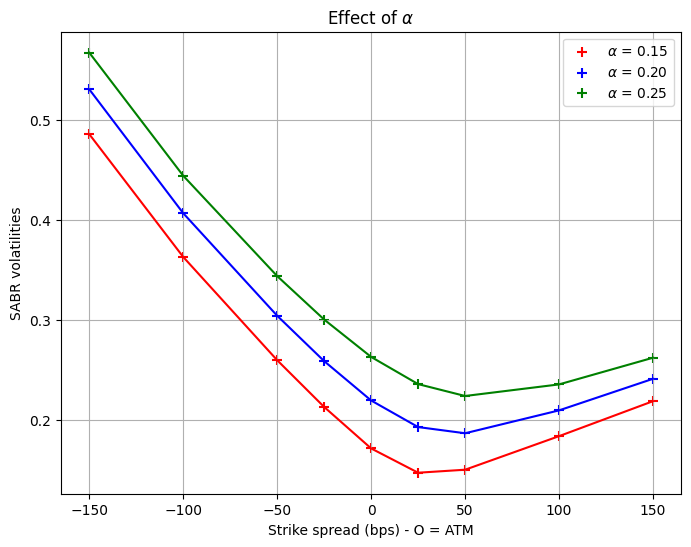

In [97]:
# Plotting the volatility smiles
SELECTED_COUPLE = 5

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(STRIKES_SPREADS, VOL_ALPHA_1.iloc[SELECTED_COUPLE,2:11], color="red", marker="+", s = 60, label=r"$\alpha$ = 0.15")
plt.scatter(STRIKES_SPREADS, VOL_ALPHA_2.iloc[SELECTED_COUPLE,2:11], color="blue", marker="+", s = 60, label=r"$\alpha$ = 0.20")
plt.scatter(STRIKES_SPREADS, VOL_ALPHA_3.iloc[SELECTED_COUPLE,2:11], color="green", marker="+", s = 60, label=r"$\alpha$ = 0.25")
plt.title(r"Effect of $\alpha$")
plt.xlabel("Strike spread (bps) - O = ATM")
plt.ylabel("SABR volatilities")
plt.grid()
plt.legend(loc="upper right")


# Interpolation
f1 = interp1d(x = STRIKES_SPREADS, 
              y=  VOL_ALPHA_1.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f2 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_ALPHA_2.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f3 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_ALPHA_3.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")

# Plot the interpolated lines
_ = plt.plot(STRIKES_SPREADS, f1(STRIKES_SPREADS), color="red")
_ = plt.plot(STRIKES_SPREADS, f2(STRIKES_SPREADS), color="blue")
_ = plt.plot(STRIKES_SPREADS, f3(STRIKES_SPREADS), color="green")

### Impact of $\beta$

In [98]:
# Creating the intermediary files

# Simulation for beta_1
f = "beta_1"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, FIXED_VALUES["ALPHA"], BETA[0], FIXED_VALUES["RHO"], FIXED_VALUES["NU"])
outvol.close()
vol_diff.close()
parameters.close()


# Simulation for beta_2
f = "beta_2"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, FIXED_VALUES["ALPHA"], BETA[1], FIXED_VALUES["RHO"], FIXED_VALUES["NU"])
outvol.close()
vol_diff.close()
parameters.close()


# Simulation for beta_3
f = "beta_3"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, FIXED_VALUES["ALPHA"], BETA[2], FIXED_VALUES["RHO"], FIXED_VALUES["NU"])
outvol.close()
vol_diff.close()
parameters.close()

# Simulation for beta_4
f = "beta_4"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, FIXED_VALUES["ALPHA"], BETA[3], FIXED_VALUES["RHO"], FIXED_VALUES["NU"])
outvol.close()
vol_diff.close()
parameters.close()

# Simulation for beta_5
f = "beta_5"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, FIXED_VALUES["ALPHA"], BETA[4], FIXED_VALUES["RHO"], FIXED_VALUES["NU"])
outvol.close()
vol_diff.close()
parameters.close()

Simulation for beta_1 	: alpha = 0.2, beta = 0.2, rho = -0.6, nu = 1.2

   	 strikes:
-150
-100
-50
-25
ATM
25
50
100
150

tenor 	 expiry
2y 	 3m
58.8236
14.6849
9.7835
8.5633
7.6737
6.9895
6.4428
5.6161
5.0142

2y 	 6m
96.5985
19.2719
11.8833
10.1605
8.9415
8.0272
7.312
6.2579
5.5118

2y 	 9m
129.178
23.2209
13.6814
11.5243
10.021
8.9081
8.0477
6.7978
5.9277

2y 	 1y
156.7569
26.5739
15.2045
12.6777
10.9322
9.6504
8.6665
7.25
6.2746

2y 	 2y
172.4488
31.6953
17.6219
14.5042
12.364
10.803
9.6134
7.918
6.7657

2y 	 5y
16.2026
11.809
9.3302
8.4565
7.7392
7.1396
6.6311
5.8147
5.1883

2y 	 10y
15.9719
12.4372
10.1792
9.3326
8.617
8.0043
7.4743
6.6037
5.9195

5y 	 3m
38.4253
11.3303
7.9096
7.0184
6.3553
5.8365
5.4161
4.7693
4.2891

5y 	 6m
35.9849
12.7389
8.6745
7.6193
6.8416
6.2393
5.7559
5.0213
4.4841

5y 	 9m
31.8401
13.3096
9.0981
7.9724
7.1386
6.492
5.973
5.1864
4.6134

5y 	 1y
28.1051
13.3657
9.2755
8.1407
7.2914
6.6285
6.0945
5.2828
4.6908

5y 	 2y
19.4719
12.1555
9.0288
8.0452
7.275

In [99]:
# Reading the files
VOL_BETA_1 = pd.read_csv("out/outvol_beta_1.csv", sep=";", header=0)
VOL_BETA_2 = pd.read_csv("out/outvol_beta_2.csv", sep=";", header=0)
VOL_BETA_3 = pd.read_csv("out/outvol_beta_3.csv", sep=";", header=0)
VOL_BETA_4 = pd.read_csv("out/outvol_beta_4.csv", sep=";", header=0)
VOL_BETA_5 = pd.read_csv("out/outvol_beta_5.csv", sep=";", header=0)

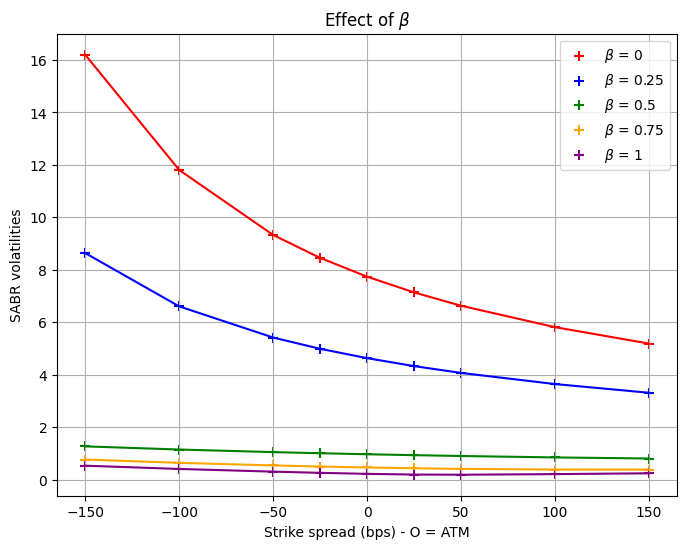

In [100]:
SELECTED_COUPLE = 5

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(STRIKES_SPREADS, VOL_BETA_1.iloc[SELECTED_COUPLE,2:11], color="red", marker="+", s = 60, label=r"$\beta$ = 0")
plt.scatter(STRIKES_SPREADS, VOL_BETA_2.iloc[SELECTED_COUPLE,2:11], color="blue", marker="+", s = 60, label=r"$\beta$ = 0.25")
plt.scatter(STRIKES_SPREADS, VOL_BETA_3.iloc[SELECTED_COUPLE,2:11], color="green", marker="+", s = 60, label=r"$\beta$ = 0.5")
plt.scatter(STRIKES_SPREADS, VOL_BETA_4.iloc[SELECTED_COUPLE,2:11], color="orange", marker="+", s = 60, label=r"$\beta$ = 0.75")
plt.scatter(STRIKES_SPREADS, VOL_BETA_5.iloc[SELECTED_COUPLE,2:11], color="purple", marker="+", s = 60, label=r"$\beta$ = 1")
plt.title(r"Effect of $\beta$")
plt.xlabel("Strike spread (bps) - O = ATM")
plt.ylabel("SABR volatilities")
plt.grid()
plt.legend(loc="upper right")


# Interpolation
f1 = interp1d(x = STRIKES_SPREADS, 
              y=  VOL_BETA_1.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f2 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_BETA_2.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f3 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_BETA_3.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f4 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_BETA_4.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f5 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_BETA_5.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")

# Plot the interpolated lines
_ = plt.plot(STRIKES_SPREADS, f1(STRIKES_SPREADS), color="red")
_ = plt.plot(STRIKES_SPREADS, f2(STRIKES_SPREADS), color="blue")
_ = plt.plot(STRIKES_SPREADS, f3(STRIKES_SPREADS), color="green")
_ = plt.plot(STRIKES_SPREADS, f4(STRIKES_SPREADS), color="orange")
_ = plt.plot(STRIKES_SPREADS, f5(STRIKES_SPREADS), color="purple")

### Impact of $\rho$

In [101]:
# Creating the intermediary files

# Simulation for rho_1
f = "rho_1"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, FIXED_VALUES["ALPHA"], FIXED_VALUES["BETA"], RHO[0], FIXED_VALUES["NU"])
outvol.close()
vol_diff.close()
parameters.close()


# Simulation for rho_2
f = "rho_2"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, FIXED_VALUES["ALPHA"], FIXED_VALUES["BETA"], RHO[1], FIXED_VALUES["NU"])
outvol.close()
vol_diff.close()
parameters.close()


# Simulation for rho_3
f = "rho_3"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, FIXED_VALUES["ALPHA"], FIXED_VALUES["BETA"], RHO[2], FIXED_VALUES["NU"])
outvol.close()
vol_diff.close()
parameters.close()

# Simulation for rho_4
f = "rho_4"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, FIXED_VALUES["ALPHA"], FIXED_VALUES["BETA"], RHO[3], FIXED_VALUES["NU"])
outvol.close()
vol_diff.close()
parameters.close()

# Simulation for rho_5
f = "rho_5"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, FIXED_VALUES["ALPHA"], FIXED_VALUES["BETA"], RHO[4], FIXED_VALUES["NU"])
outvol.close()
vol_diff.close()
parameters.close()

Simulation for rho_1 	: alpha = 0.2, beta = 1, rho = -0.75, nu = 1.2

   	 strikes:
-150
-100
-50
-25
ATM
25
50
100
150

tenor 	 expiry
2y 	 3m
0.9965
0.4387
0.1891
0.1502
0.1813
0.2143
0.2436
0.2922
0.3314

2y 	 6m
0.9985
0.4469
0.2014
0.147
0.1735
0.2059
0.2349
0.2834
0.3225

2y 	 9m
1.004
0.4597
0.2199
0.1472
0.1634
0.1945
0.2233
0.2716
0.3106

2y 	 1y
1.0108
0.474
0.2403
0.1557
0.1534
0.1822
0.2105
0.2587
0.2977

2y 	 2y
1.0111
0.5435
0.3405
0.261
0.1895
0.1431
0.1488
0.1911
0.2295

2y 	 5y
0.4353
0.3341
0.249
0.2101
0.1738
0.1437
0.1297
0.1414
0.1639

2y 	 10y
0.3258
0.2594
0.2006
0.1732
0.1475
0.1254
0.112
0.1146
0.1298

5y 	 3m
1.1012
0.5759
0.359
0.2746
0.1987
0.1499
0.1565
0.2013
0.2418

5y 	 6m
0.9498
0.5472
0.3484
0.2691
0.1974
0.1497
0.1537
0.1959
0.235

5y 	 9m
0.8453
0.5199
0.3379
0.2635
0.1961
0.1498
0.151
0.1904
0.228

5y 	 1y
0.7674
0.4949
0.3278
0.2582
0.1948
0.1499
0.1485
0.185
0.2212

5y 	 2y
0.5899
0.4211
0.2955
0.2404
0.1895
0.1504
0.1414
0.1673
0.1981

5y 	 5y
0.

In [102]:
VOL_RHO_1 = pd.read_csv("out/outvol_rho_1.csv", sep=";", header=0)
VOL_RHO_2 = pd.read_csv("out/outvol_rho_2.csv", sep=";", header=0)
VOL_RHO_3 = pd.read_csv("out/outvol_rho_3.csv", sep=";", header=0)
VOL_RHO_4 = pd.read_csv("out/outvol_rho_4.csv", sep=";", header=0)
VOL_RHO_5 = pd.read_csv("out/outvol_rho_5.csv", sep=";", header=0)

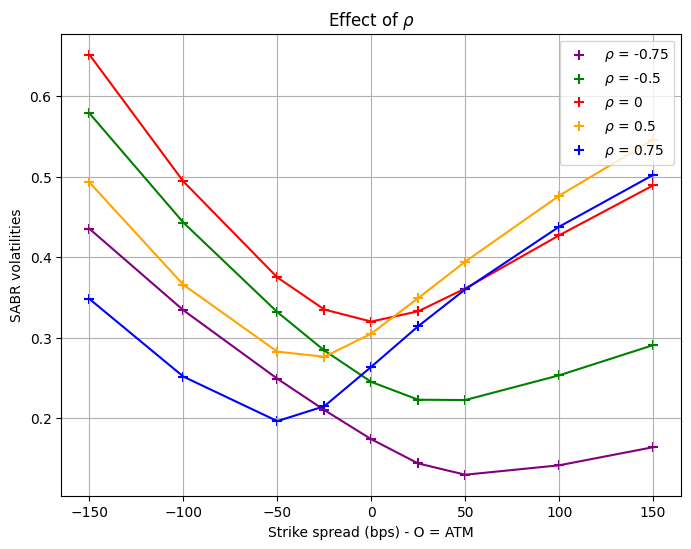

In [103]:
SELECTED_COUPLE = 5

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(STRIKES_SPREADS, VOL_RHO_1.iloc[SELECTED_COUPLE,2:11], color="purple", marker="+", s = 60, label=r"$\rho$ = -0.75")
plt.scatter(STRIKES_SPREADS, VOL_RHO_2.iloc[SELECTED_COUPLE,2:11], color="green", marker="+", s = 60, label=r"$\rho$ = -0.5")
plt.scatter(STRIKES_SPREADS, VOL_RHO_3.iloc[SELECTED_COUPLE,2:11], color="red", marker="+", s = 60, label=r"$\rho$ = 0")
plt.scatter(STRIKES_SPREADS, VOL_RHO_4.iloc[SELECTED_COUPLE,2:11], color="orange", marker="+", s = 60, label=r"$\rho$ = 0.5")
plt.scatter(STRIKES_SPREADS, VOL_RHO_5.iloc[SELECTED_COUPLE,2:11], color="blue", marker="+", s = 60, label=r"$\rho$ = 0.75")
plt.title(r"Effect of $\rho$")
plt.xlabel("Strike spread (bps) - O = ATM")
plt.ylabel("SABR volatilities")
plt.grid()
plt.legend(loc="upper right")


# Interpolation
f1 = interp1d(x = STRIKES_SPREADS, 
              y=  VOL_RHO_1.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f2 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_RHO_2.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f3 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_RHO_3.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f4 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_RHO_4.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f5 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_RHO_5.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")

# Plot the interpolated lines
_ = plt.plot(STRIKES_SPREADS, f1(STRIKES_SPREADS), color="purple")
_ = plt.plot(STRIKES_SPREADS, f2(STRIKES_SPREADS), color="green")
_ = plt.plot(STRIKES_SPREADS, f3(STRIKES_SPREADS), color="red")
_ = plt.plot(STRIKES_SPREADS, f4(STRIKES_SPREADS), color="orange")
_ = plt.plot(STRIKES_SPREADS, f5(STRIKES_SPREADS), color="blue")

### Impact of $\nu$

In [104]:
# Creating the intermediary files

# Simulation for nu_1
f = "nu_1"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, FIXED_VALUES["ALPHA"], FIXED_VALUES["BETA"], FIXED_VALUES["RHO"], NU[0])
outvol.close()
vol_diff.close()
parameters.close()


# Simulation for nu_2
f = "nu_2"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, FIXED_VALUES["ALPHA"], FIXED_VALUES["BETA"], FIXED_VALUES["RHO"], NU[1])
outvol.close()
vol_diff.close()
parameters.close()


# Simulation for nu_3
f = "nu_3"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, FIXED_VALUES["ALPHA"], FIXED_VALUES["BETA"], FIXED_VALUES["RHO"], NU[2])
outvol.close()
vol_diff.close()
parameters.close()

# Simulation for nu_4
f = "nu_4"
SUFFIX, PREFIX = f, "out/"
outvol = open(f'{PREFIX}outvol_{SUFFIX}.csv', 'w')
vol_diff = open(f'{PREFIX}vol_diff_{SUFFIX}.csv', 'w')
parameters = open(f'{PREFIX}parameters_{SUFFIX}.csv', 'w')
study_parameter(f, FIXED_VALUES["ALPHA"], FIXED_VALUES["BETA"], FIXED_VALUES["RHO"], NU[3])
outvol.close()
vol_diff.close()
parameters.close()

Simulation for nu_1 	: alpha = 0.2, beta = 1, rho = -0.6, nu = 0.5

   	 strikes:
-150
-100
-50
-25
ATM
25
50
100
150

tenor 	 expiry
2y 	 3m
0.5637
0.2971
0.1965
0.1737
0.17
0.1764
0.1859
0.2058
0.2237

2y 	 6m
0.5671
0.3018
0.2008
0.1758
0.1694
0.1743
0.1831
0.2025
0.2203

2y 	 9m
0.5723
0.3087
0.2074
0.1796
0.1694
0.1718
0.1795
0.198
0.2154

2y 	 1y
0.5782
0.3164
0.2151
0.185
0.1706
0.1698
0.1758
0.193
0.2101

2y 	 2y
0.5889
0.3547
0.2584
0.2245
0.1978
0.1792
0.1698
0.1713
0.1831

2y 	 5y
0.316
0.2648
0.2251
0.2087
0.1946
0.1831
0.1744
0.1659
0.1663

2y 	 10y
0.2815
0.244
0.2134
0.2005
0.1892
0.1796
0.172
0.1628
0.1607

5y 	 3m
0.6145
0.361
0.2617
0.227
0.1997
0.1808
0.1713
0.1731
0.1853

5y 	 6m
0.5433
0.3487
0.2578
0.2253
0.1995
0.1812
0.1716
0.172
0.1832

5y 	 9m
0.4945
0.337
0.2539
0.2235
0.1992
0.1817
0.1719
0.171
0.1811

5y 	 1y
0.4583
0.3263
0.2502
0.2218
0.1989
0.1821
0.1723
0.1702
0.179

5y 	 2y
0.3776
0.2956
0.2388
0.2164
0.1978
0.1835
0.1739
0.168
0.173

5y 	 5y
0.3042
0.

In [105]:
VOL_NU_1 = pd.read_csv("out/outvol_nu_1.csv", sep=";", header=0)
VOL_NU_2 = pd.read_csv("out/outvol_nu_2.csv", sep=";", header=0)
VOL_NU_3 = pd.read_csv("out/outvol_nu_3.csv", sep=";", header=0)
VOL_NU_4 = pd.read_csv("out/outvol_nu_4.csv", sep=";", header=0)

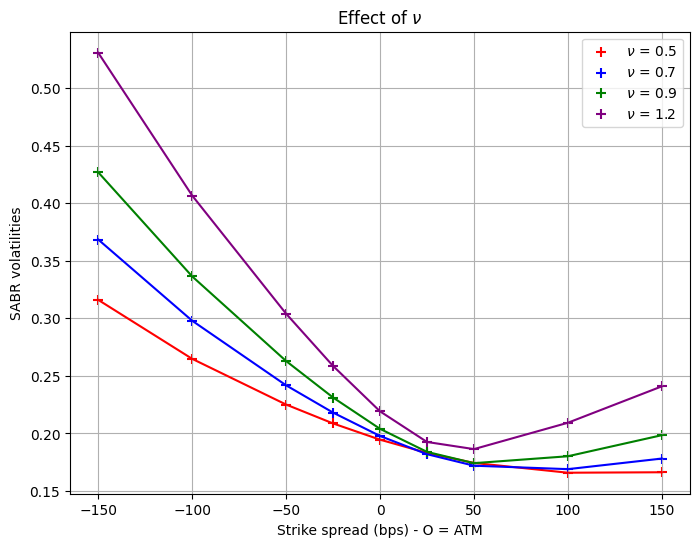

In [107]:
SELECTED_COUPLE = 5

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(STRIKES_SPREADS, VOL_NU_1.iloc[SELECTED_COUPLE,2:11], color="red", marker="+", s = 60, label=r"$\nu$ = 0.5")
plt.scatter(STRIKES_SPREADS, VOL_NU_2.iloc[SELECTED_COUPLE,2:11], color="blue", marker="+", s = 60, label=r"$\nu$ = 0.7")
plt.scatter(STRIKES_SPREADS, VOL_NU_3.iloc[SELECTED_COUPLE,2:11], color="green", marker="+", s = 60, label=r"$\nu$ = 0.9")
plt.scatter(STRIKES_SPREADS, VOL_NU_4.iloc[SELECTED_COUPLE,2:11], color="purple", marker="+", s = 60, label=r"$\nu$ = 1.2")
plt.title(r"Effect of $\nu$")
plt.xlabel("Strike spread (bps) - O = ATM")
plt.ylabel("SABR volatilities")
plt.grid()
plt.legend(loc="upper right")


# Interpolation
f1 = interp1d(x = STRIKES_SPREADS, 
              y=  VOL_NU_1.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f2 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_NU_2.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f3 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_NU_3.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")
f4 = interp1d(x = STRIKES_SPREADS, 
              y= VOL_NU_4.iloc[SELECTED_COUPLE,2:11],
              kind = "cubic")

# Plot the interpolated lines
_ = plt.plot(STRIKES_SPREADS, f1(STRIKES_SPREADS), color="red")
_ = plt.plot(STRIKES_SPREADS, f2(STRIKES_SPREADS), color="blue")
_ = plt.plot(STRIKES_SPREADS, f3(STRIKES_SPREADS), color="green")
_ = plt.plot(STRIKES_SPREADS, f4(STRIKES_SPREADS), color="purple")

All the associated remarks and comments are available in the attached PDF report.

---

**Amal BACHA - Lucas RODRIGUEZ** - Octover/November 2022